Data loaded. Shape: (6929, 98)
Removed highly correlated numeric features: ['HE_LDL_drct', 'HE_alt', 'HE_wt', 'HE_BMI']
Selected numeric features after correlation check: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'HE_ht', 'age', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT']

=== Iteration 1: Baseline Clustering (Full initial feature set) ===

--- Running Iteration with 23 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'HE_ht', 'age', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT']
Categorical columns in current df: ['BD1_11', 'BP16_1', 'BS3_2', 'BE5_1', 'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5']
Shape after preprocessing (scaled and OHE): (6929, 86)
PCA reduced dimensions to: 32
Explained variance ratio: 0.9541

--- Running Agglomerative (k=5) ---
Agglomerative (k=5): Silhouette Score = 0.1075

Feature Importance (Random Forest) f

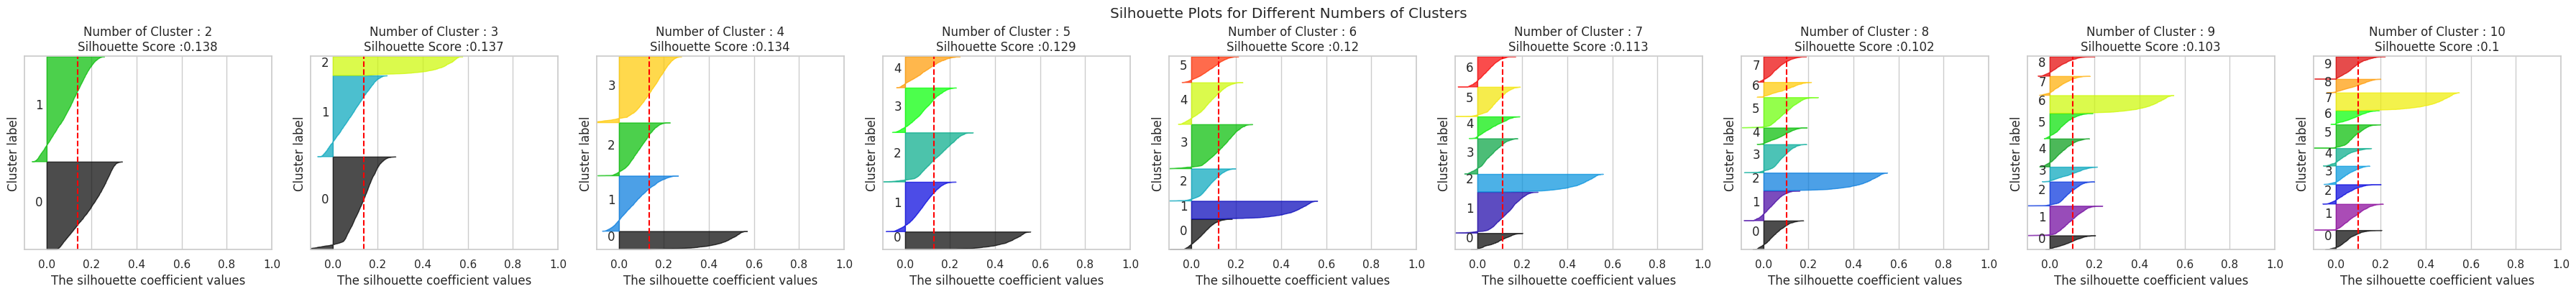


--- Analyzing Feature Importance for Selection ---
Feature importance threshold for removal (median): 0.033359

Identified 11 low importance features to potentially remove.
Remaining features for Iteration 2: 12

=== Iteration 2: Clustering with Selected Features ===

--- Running Iteration with 12 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_glu', 'HE_HbA1c', 'HE_crea', 'HE_ht', 'age']
Categorical columns in current df: ['BP16_1', 'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5']
Shape after preprocessing (scaled and OHE): (6929, 38)
PCA reduced dimensions to: 16
Explained variance ratio: 0.9517

--- Running Agglomerative (k=5) ---
Agglomerative (k=5): Silhouette Score = 0.1816

Feature Importance (Random Forest) for non-noise clusters:
sex            0.212540
HE_DM_HbA1c    0.132492
HE_HP          0.095736
age            0.095599
HE_HbA1c       0.091866
HE_ht          0.082968
HE_glu         0.078650
HE_crea        0.049425
BP5            0.043500
B

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트
from scipy import stats
import statsmodels.api as sm # 카이제곱 검정 결과를 좀 더 상세히 보여주기 위해 추가 (Optional)
from statsmodels.stats.contingency_tables import Table # 카이제곱 검정을 위한 클래스

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 수정 (이전 코드와 동일)
def preprocess_data(df, original_numeric_cols, original_categorical_cols):
    """
    Preprocess data: impute missing values, handle outliers, encode categorical features.
    Processes only the columns present in the input df, based on original_numeric_cols and original_categorical_cols.
    """
    df_processed = df.copy()

    current_numeric_cols = [col for col in original_numeric_cols if col in df_processed.columns]
    current_categorical_cols = [col for col in original_categorical_cols if col in df_processed.columns]

    print(f"\n--- Preprocessing ---")
    print(f"Numeric columns in current df: {current_numeric_cols}")
    print(f"Categorical columns in current df: {current_categorical_cols}")

    df_processed = df_processed.replace([888, 999], np.nan)

    if current_numeric_cols:
        numeric_data_for_impute = df_processed[current_numeric_cols].values
        imputer = KNNImputer(n_neighbors=5)
        numeric_data_imputed = imputer.fit_transform(numeric_data_for_impute)
        df_processed[current_numeric_cols] = numeric_data_imputed

    if current_categorical_cols:
        for col in current_categorical_cols:
             if df_processed[col].isnull().any():
                 try:
                     mode_val = df_processed[col].mode()[0]
                     df_processed[col] = df_processed[col].fillna(mode_val)
                 except IndexError:
                     print(f"Warning: Could not compute mode for {col} or all values are NaN.")
                     pass

    if current_numeric_cols:
        for col in current_numeric_cols:
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)

    transformers = []
    if current_numeric_cols:
        transformers.append(('num', RobustScaler(), current_numeric_cols))
    if current_categorical_cols:
         transformers.append(('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), current_categorical_cols))

    if not transformers:
        print("No numeric or categorical columns remaining after filtering.")
        return pd.DataFrame(), [], None, df_processed

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough'
    )

    try:
        scaled_data = preprocessor.fit_transform(df_processed)
        all_transformed_features = preprocessor.get_feature_names_out()
        scaled_df = pd.DataFrame(scaled_data, columns=all_transformed_features)
        print(f"Shape after preprocessing (scaled and OHE): {scaled_df.shape}")
    except Exception as e:
        print(f"Error during preprocessing transformation: {e}")
        return pd.DataFrame(), [], None, df_processed

    return scaled_df, all_transformed_features, preprocessor, df_processed

# select_features 함수 (이전 코드와 동일)
def select_features(df, columns, corr_threshold=0.8):
    """Remove highly correlated numeric features."""
    numeric_df = df[columns].select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns provided for correlation check.")
        return []

    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    selected_numeric_cols = [col for col in columns if col not in to_drop]
    print(f"Removed highly correlated numeric features: {to_drop}")
    print(f"Selected numeric features after correlation check: {selected_numeric_cols}")
    return selected_numeric_cols

# compute_feature_importance 함수 (이전 코드와 동일)
def compute_feature_importance(df_processed, selected_cols, cluster_labels):
    """Compute feature importance using Random Forest."""
    if len(np.unique(cluster_labels[cluster_labels != -1])) < 2:
         print("\nFeature Importance: Not enough non-noise clusters (>= 2 required).")
         return pd.Series([], dtype=float)

    non_noise_indices = cluster_labels != -1
    df_filtered = df_processed.loc[non_noise_indices].copy()
    labels_filtered = cluster_labels[non_noise_indices]

    if df_filtered.empty:
         print("\nFeature Importance: No non-noise data points found.")
         return pd.Series([], dtype=float)

    try:
        rf = RandomForestClassifier(random_state=42)
        rf.fit(df_filtered[selected_cols], labels_filtered)
        importance = pd.Series(rf.feature_importances_, index=selected_cols).sort_values(ascending=False)
        print("\nFeature Importance (Random Forest) for non-noise clusters:")
        print(importance)
        return importance
    except Exception as e:
        print(f"\nError computing Feature Importance: {e}")
        return pd.Series([], dtype=float)

# visualize_silhouette 함수 (이전 코드와 동일)
def visualize_silhouette(cluster_lists, X_features):
    """
    주어진 클러스터 개수 리스트에 대해 K-Means를 적용하고 실루엣 계수를 시각화합니다.

    Args:
        cluster_lists (list): 테스트할 클러스터 개수(k)의 리스트.
        X_features (numpy.ndarray or pandas.DataFrame): 클러스터링 대상 데이터 (PCA 결과 등).
    """
    print(f"\n--- Visualizing Silhouette Scores for k in {cluster_lists} ---")

    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)
    if n_cols == 1: # axs가 배열이 아닐 경우 처리
        axs = [axs]

    for ind, n_cluster in enumerate(cluster_lists):
        ax = axs[ind] # 각 서브플롯 선택

        try:
            if n_cluster < 2:
                 print(f"Skipping silhouette visualization for k={n_cluster} (< 2).")
                 ax.set_title(f'k={n_cluster} (Skipped)')
                 ax.text(0.5, 0.5, 'k < 2', horizontalalignment='center', verticalalignment='center')
                 ax.set_xticks([])
                 ax.set_yticks([])
                 continue # 다음 k로 넘어감

            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init=10)
            cluster_labels = clusterer.fit_predict(X_features)

            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)

            y_lower = 10

            ax.set_title('Number of Cluster : ' + str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")
            ax.set_xlim([-0.1, 1])
            ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
            ax.set_yticks([])
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            for i in range(n_cluster):
                ith_cluster_sil_values = sil_values[cluster_labels == i]
                ith_cluster_sil_values.sort()
                size_cluster_i = ith_cluster_sil_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = cm.nipy_spectral(float(i) / n_cluster)
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, ith_cluster_sil_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            ax.axvline(x=sil_avg, color="red", linestyle="--")

        except Exception as e:
            print(f"Error visualizing silhouette for k={n_cluster}: {e}")
            ax.set_title(f'k={n_cluster} (Error)')
            ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.suptitle('Silhouette Plots for Different Numbers of Clusters', y=1.02)
    plt.show()


# 단일 클러스터링 이터레이션을 실행하는 함수 (이전 코드와 동일)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca instead of scaled_df for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        return None, None, None, None, None, None, None # scaled_df_pca 추가 반환값

    df_subset = df_original[features_to_use]

    try:
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df.empty:
             print("Preprocessing returned empty data. Skipping iteration.")
             return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
         print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
         return features_to_use, None, None, None, None, None, None

    pca = PCA(n_components=0.95, random_state=42)
    scaled_df_pca = None
    try:
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
         print(f"PCA failed: {e}. Skipping clustering and importance.")
         return features_to_use, None, None, None, df_processed_subset, scaled_df, None # scaled_df_pca None

    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None # scaled_df_pca None


    clusters = None
    score = None
    algorithm_used = None

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
             algorithm_used = f'KMeans (k={n_clusters})'
             print(f"\n--- Running {algorithm_used} ---")
             model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
             clusters = model.fit_predict(scaled_df_pca)

        # 실루엣 스코어 계산
        if len(np.unique(clusters)) > 1 and not (len(np.unique(clusters)) == 2 and -1 in np.unique(clusters)):
             # DBSCAN의 경우 노이즈(-1) 제외 필요. 현재 Agglomerative/KMeans 사용하므로 모든 클러스터 포함
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 non-noise clusters).")
             score = None

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None
        score = None


    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None

    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # scaled_df_pca도 함께 반환하여 분석 및 시각화에 사용
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


# --- 군집별 피처 차이 통계 분석 함수 추가 ---
def analyze_cluster_differences(df_processed, clusters, features_used, original_numeric_cols, original_categorical_cols, alpha=0.05):
    """
    Performs statistical tests to check for significant differences in features across clusters.
    ANOVA for numeric features, Chi-squared for categorical features.
    """
    print(f"\n=== Analyzing Statistical Differences Across Clusters (alpha={alpha}) ===")

    if df_processed is None or clusters is None:
        print("Analysis skipped: Processed data or cluster labels are missing.")
        return

    # 노이즈(-1) 클러스터는 분석에서 제외
    non_noise_indices = clusters != -1
    df_filtered = df_processed.loc[non_noise_indices].copy()
    clusters_filtered = clusters[non_noise_indices]

    if len(np.unique(clusters_filtered)) < 2:
        print("Analysis skipped: Less than 2 non-noise clusters found.")
        return

    df_filtered['Cluster'] = clusters_filtered

    # 사용된 피처들을 숫자형과 범주형으로 분리
    numeric_features_used = [col for col in features_used if col in original_numeric_cols]
    categorical_features_used = [col for col in features_used if col in original_categorical_cols]

    print("\n--- ANOVA Test for Numeric Features ---")
    if not numeric_features_used:
        print("No numeric features to test.")
    else:
        for col in numeric_features_used:
            # 각 군집별 데이터 그룹 추출
            # 클러스터 인덱스가 숫자로 자동 변환되므로 astype(int) 필요 없음
            groups = [df_filtered[col][df_filtered['Cluster'] == i].dropna() for i in np.unique(clusters_filtered)]

            # 샘플 수가 1개 이하인 그룹은 ANOVA에서 제외해야 함
            valid_groups = [group for group in groups if len(group) > 1]

            if len(valid_groups) < 2:
                print(f"  '{col}': ANOVA skipped (less than 2 groups with >1 sample).")
                continue

            # 모든 그룹에서 해당 피처의 값이 동일한지 확인 (ANOVA 오류 방지)
            all_values = np.concatenate(valid_groups)
            if np.all(all_values == all_values[0]):
                 print(f"  '{col}': ANOVA skipped (feature has constant value across groups).")
                 continue


            # ANOVA 검정 실행
            try:
                fvalue, pvalue = stats.f_oneway(*valid_groups)
                print(f"  '{col}': F-statistic={fvalue:.4f}, p-value={pvalue:.4f} {'*' if pvalue < alpha else ''}")
            except Exception as e:
                print(f"  '{col}': ANOVA failed ({e}).")


    print("\n--- Chi-squared Test for Categorical Features ---")
    if not categorical_features_used:
        print("No categorical features to test.")
    else:
        for col in categorical_features_used:
            # 교차표 생성
            contingency_table = pd.crosstab(df_filtered['Cluster'], df_filtered[col])

            # 카이제곱 검정을 위한 최소 요구사항 충족 확인
            # 보통 expected frequency가 5 미만인 셀이 전체 셀의 20%를 넘지 않아야 함
            # stats.chi2_contingency는 작은 샘플 크기에 대해 경고를 띄우거나 Yates 보정을 적용할 수 있음
            # 여기서는 일단 바로 실행
            if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
                 print(f"  '{col}': Chi-squared skipped (table size < 2x2).")
                 continue

            # 모든 행 또는 열의 합이 0인지 확인 (카이제곱 오류 방지)
            if np.any(contingency_table.sum(axis=0) == 0) or np.any(contingency_table.sum(axis=1) == 0):
                 print(f"  '{col}': Chi-squared skipped (zero row/column sum).")
                 continue

            try:
                chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
                print(f"  '{col}': Chi2-statistic={chi2:.4f}, p-value={p:.4f}, df={dof} {'*' if p < alpha else ''}")

                # statsmodels를 사용하면 더 상세한 결과 확인 가능 (Optional)
                # table = Table(contingency_table)
                # rslt = table.test_nominal_association()
                # print(rslt.pvalue)

            except ValueError as ve:
                 print(f"  '{col}': Chi-squared failed ({ve}). Check for zero counts or other table issues.")
            except Exception as e:
                print(f"  '{col}': Chi-squared failed ({e}).")

    print("\n(*) indicates statistically significant difference (p < alpha)")


# run_clustering_iteration 함수 반환값 수정 (scaled_df_pca 추가)
# run_clustering_iteration 함수 (이전 코드와 동일)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        # scaled_df_pca 추가 반환값 None
        return None, None, None, None, None, None, None

    df_subset = df_original[features_to_use].copy() # 복사본 사용

    try:
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df.empty:
             print("Preprocessing returned empty data. Skipping iteration.")
             return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
         print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
         return features_to_use, None, None, None, None, None, None

    pca = PCA(n_components=0.95, random_state=42)
    scaled_df_pca = None
    try:
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
         print(f"PCA failed: {e}. Skipping clustering and importance.")
         return features_to_use, None, None, None, df_processed_subset, scaled_df, None

    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None


    clusters = None
    score = None
    algorithm_used = None

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
             algorithm_used = f'KMeans (k={n_clusters})'
             print(f"\n--- Running {algorithm_used} ---")
             model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
             clusters = model.fit_predict(scaled_df_pca)

        else:
            raise ValueError(f"Unsupported algorithm: {algorithm}")

        if len(np.unique(clusters)) > 1 and not (len(np.unique(clusters)) == 2 and -1 in np.unique(clusters)):
             # DBSCAN의 경우 노이즈(-1) 제외 필요. 현재 Agglomerative/KMeans 사용하므로 모든 클러스터 포함
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 non-noise clusters).")
             score = None

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None
        score = None


    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None

    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # scaled_df_pca도 함께 반환하여 분석에 사용
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


def main():
    """Iterative feature selection for clustering and statistical analysis."""
    # 데이터 로드
    df_original = pd.read_csv("/content/선택컬럼_건강데이터.csv")
    print(f"Data loaded. Shape: {df_original.shape}")

    # 원본 전체 피처 정의
    knn_columns = [
        'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c',
        'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
        'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
    ]
    additional_numeric = ['age', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT']
    additional_categorical = ['HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5']
    original_categorical = ["BD1_11", "BP16_1", "BS3_2", "BE5_1"]

    all_possible_numeric_cols = knn_columns + additional_numeric
    all_possible_categorical_cols = original_categorical + additional_categorical

    # 초기 숫자형 피처 상관관계 기반 필터링 (후보군 축소)
    selected_numeric_after_corr = select_features(df_original.copy(), all_possible_numeric_cols, corr_threshold=0.8)
    current_features_for_selection = selected_numeric_after_corr + all_possible_categorical_cols

    if not current_features_for_selection:
         print("No features remaining after initial correlation check. Exiting.")
         return

    # 클러스터링 매개변수 설정
    n_clusters_to_use = 5 # <-- 군집 개수를 5개로 고정!
    clustering_algorithm = 'Agglomerative' # 사용할 알고리즘 선택 ('Agglomerative' 또는 'KMeans')


    # --- Iteration 1: Baseline Clustering with initial feature set ---
    print("\n=== Iteration 1: Baseline Clustering (Full initial feature set) ===")
    # run_clustering_iteration 함수는 이제 scaled_df_pca도 반환
    features_iter1, clusters_iter1, score_iter1, importance_iter1, df_processed_iter1, scaled_df_iter1, scaled_df_pca_iter1 = run_clustering_iteration(
        df_original,
        current_features_for_selection,
        all_possible_numeric_cols,
        all_possible_categorical_cols,
        n_clusters=n_clusters_to_use,
        algorithm=clustering_algorithm
    )

    print(f"\nIteration 1 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter1 if score_iter1 is not None else 'N/A':.4f}")

    # --- Silhouette Plot Visualization for Different k (using Iteration 1 PCA data) ---
    # 이 시각화는 k=5로 고정된 분석과는 별개로, 다양한 k를 탐색하며 시각적으로 좋은 k를 찾는데 도움을 줍니다.
    # 따라서 n_clusters_to_use와 관계없이 k_range_for_viz를 사용합니다.
    # 시각화는 Iteration 1의 scaled_df 데이터를 사용합니다.
    if scaled_df_iter1 is not None and not scaled_df_iter1.empty:
        pca_for_viz = PCA(n_components=0.95, random_state=42)
        try:
            scaled_df_pca_for_viz = pca_for_viz.fit_transform(scaled_df_iter1)
            k_range_for_viz = range(2, 11) # 시각화를 위한 k 범위
            visualize_silhouette(list(k_range_for_viz), scaled_df_pca_for_viz)
        except Exception as e:
            print(f"Error during PCA or visualization for silhouette plot: {e}")
    else:
         print("\nSkipping silhouette visualization due to empty or None scaled_df from Iteration 1.")


    # 이후 피처 선택 및 Iteration 2 진행 로직은 그대로 유지
    # best 결과는 Iteration 1 또는 2 중 더 나은 실루엣 점수를 기준으로 선택됩니다.

    best_features = features_iter1
    best_clusters = clusters_iter1
    best_score = score_iter1
    best_df_processed = df_processed_iter1
    best_scaled_df = scaled_df_iter1
    best_scaled_df_pca = scaled_df_pca_iter1 # PCA 결과도 저장
    selected_iteration = 1 # 기본값

    # 피처 중요도 기반 이터레이션을 진행할지 여부 확인
    if importance_iter1 is not None and not importance_iter1.empty and score_iter1 is not None:
         # Iteration 1 결과가 유효할 경우에만 Iteration 2 진행
        # --- Feature Selection Based on Importance from Iteration 1 ---
        print("\n--- Analyzing Feature Importance for Selection ---")
        importance_threshold = importance_iter1.median()
        print(f"Feature importance threshold for removal (median): {importance_threshold:.6f}")

        low_importance_features = importance_iter1[importance_iter1 < importance_threshold].index.tolist()
        features_for_iteration_2 = [f for f in current_features_for_selection if f not in low_importance_features]

        print(f"\nIdentified {len(low_importance_features)} low importance features to potentially remove.")
        print(f"Remaining features for Iteration 2: {len(features_for_iteration_2)}")

        min_features = 5
        if len(features_for_iteration_2) < min_features:
            print(f"\nWarning: Number of features dropped too low. Keeping minimum {min_features} features.")
            features_for_iteration_2 = importance_iter1.nlargest(min_features).index.tolist()
            print(f"Features kept (top {min_features}): {features_for_iteration_2}")

        if not features_for_iteration_2 or len(features_for_iteration_2) < 2: # 최소 2개 피처 필요
             print(f"\nNot enough features remaining ({len(features_for_iteration_2)}) for Iteration 2. Skipping.")
        else:
            # --- Iteration 2: Clustering with Selected Features ---
            print("\n=== Iteration 2: Clustering with Selected Features ===")
            features_iter2, clusters_iter2, score_iter2, importance_iter2, df_processed_iter2, scaled_df_iter2, scaled_df_pca_iter2 = run_clustering_iteration(
                df_original,
                features_for_iteration_2,
                all_possible_numeric_cols,
                all_possible_categorical_cols,
                n_clusters=n_clusters_to_use,
                algorithm=clustering_algorithm
            )

            print(f"\nIteration 2 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # --- Compare Results and Select Best ---
            print("\n--- Comparing Iteration Results ---")
            print(f"Iteration 1 Score: {score_iter1 if score_iter1 is not None else 'N/A':.4f}")
            print(f"Iteration 2 Score: {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            if score_iter2 is not None and (score_iter1 is None or score_iter2 > score_iter1):
                print("Iteration 2 resulted in a better (or the first valid) Silhouette Score.")
                best_features = features_iter2
                best_clusters = clusters_iter2
                best_score = score_iter2
                best_df_processed = df_processed_iter2
                best_scaled_df = scaled_df_iter2
                best_scaled_df_pca = scaled_df_pca_iter2
                selected_iteration = 2
            elif score_iter1 is not None:
                print("Iteration 1 resulted in a better or equal Silhouette Score.")
                pass
            else:
                print("Neither iteration produced a valid Silhouette Score.")
                # 분석할 결과가 없으므로 여기서 종료 (best_clusters 등이 None일 수 있음)
                best_clusters = None # 명시적으로 None 설정


    if best_clusters is None:
         print("\nNo valid clustering results to analyze after iterations. Exiting.")
         return

    # --- Final Analysis and Visualization for the Best Result (k=5) ---
    print(f"\n--- Final Analysis using Result from Iteration {selected_iteration} ({clustering_algorithm}, k={n_clusters_to_use}) ---")
    print(f"Best Silhouette Score: {best_score if best_score is not None else 'N/A':.4f}")
    print(f"Features used in best result ({len(best_features)}): {best_features}")


    # 클러스터 결과 저장 (원본 df에 추가)
    df_original['Cluster'] = best_clusters


    # 군집별 특징 (Best 이터레이션의 전처리된 df_processed를 사용)
    df_with_labels = best_df_processed.copy()
    df_with_labels['Cluster'] = best_clusters

    # 노이즈(-1) 군집은 통계에서 제외
    cluster_characteristics = df_with_labels[df_with_labels['Cluster'] != -1].groupby('Cluster')[best_features].mean()
    print("\nCluster Characteristics (Mean values per feature, excluding noise points if any):")
    print(cluster_characteristics)
    print("-" * 60)


    # --- 군집별 피처 통계적 차이 분석 실행 (ANOVA, Chi-squared) ---
    # alpha 값을 조정하여 유의수준 변경 가능 (예: 0.01)
    analyze_cluster_differences(best_df_processed, best_clusters, best_features, all_possible_numeric_cols, all_possible_categorical_cols, alpha=0.05)


    # 피처 중요도 출력 (Best 이터레이션 결과 사용)
    print(f"\nFeature Importance from Iteration {selected_iteration}:")
    if selected_iteration == 1 and importance_iter1 is not None:
         print(importance_iter1)
    elif selected_iteration == 2 and importance_iter2 is not None:
         print(importance_iter2)
    else:
         print("Feature importance not available for the selected iteration.")


    # PCA 시각화 (2D) - Best 이터레이션 결과로 그리기
    # best_scaled_df는 OHE까지 된 데이터프레임
    if best_scaled_df is not None and not best_scaled_df.empty:
        pca_2d = PCA(n_components=2, random_state=42)
        try:
            pca_result_2d = pca_2d.fit_transform(best_scaled_df)
            pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
            pca_df_2d['Cluster'] = best_clusters.astype(str)

            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60, alpha=0.7)
            plt.title(f'PCA Visualization ({clustering_algorithm}, k={n_clusters_to_use}) Iteration {selected_iteration}')
            plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
            plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.savefig(f'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png')
            plt.close()
            print(f"\nPCA plot saved as 'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png'")
        except Exception as e:
            print(f"\nError generating PCA visualization: {e}")
    else:
        print("\nCould not generate PCA visualization (scaled_df for best result is None or empty).")


    # 클러스터 분포 출력 (노이즈 포함)
    print("\nCluster Distribution:")
    print(df_original['Cluster'].value_counts().sort_index())

    # HE_HP와 클러스터 교차표 (원본 df 사용)
    print("\nCross-tabulation with HE_HP:")
    print(pd.crosstab(df_original['Cluster'], df_original['HE_HP']))


    # 결과 CSV 저장 (원본 df에 클러스터 컬럼 추가된 상태)
    df_original.to_csv(f'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv', index=False)
    print(f"\nClustering results saved to 'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv'")


if __name__ == "__main__":
    main()

Data loaded. Shape: (6929, 98)

Numeric columns found in data: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_BMI', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns found in data: ['HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5', 'BD1_11', 'BP16_1', 'BS3_2', 'BE5_1']
Removed highly correlated numeric features (>0.8): ['HE_LDL_drct', 'HE_alt', 'HE_BMI']
Selected numeric features after correlation check: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']

Initial features for clustering (20): ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1', 'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5', 'BD1_11', 'BP16_1', 'BS3_2', 'BE5_1']

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_F

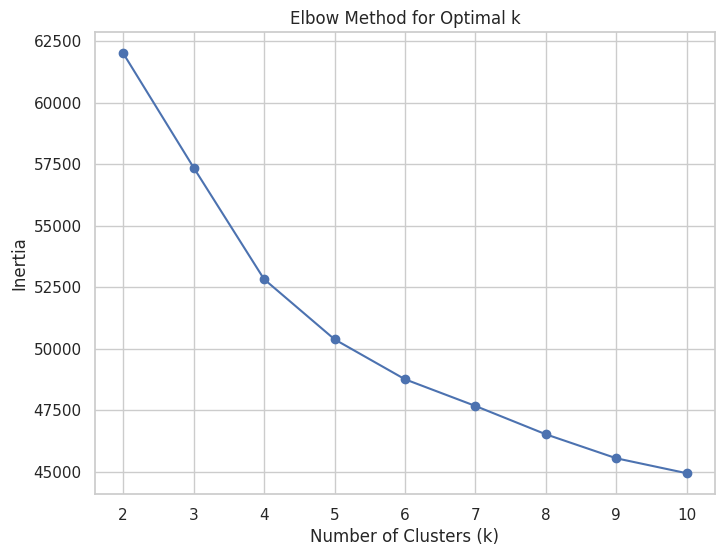


--- Visualizing Silhouette Scores for k in [2, 3, 4, 5, 6, 7, 8, 9, 10] ---


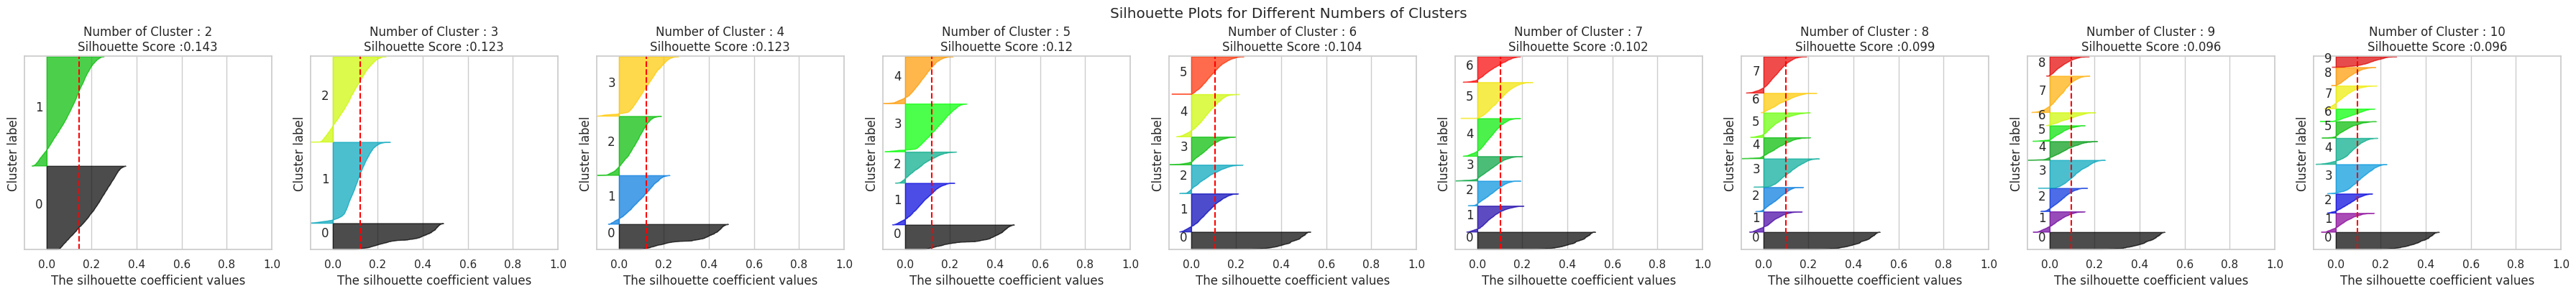


>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<
>>> Currently using optimal_k = 4 (example value). <<<

=== Iteration 1: Baseline Clustering (KMeans, k=4) ===

--- Running Iteration with 20 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns in current df: ['HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5', 'BD1_11', 'BP16_1', 'BS3_2', 'BE5_1']
Shape after preprocessing (scaled and OHE): (6929, 83)
PCA reduced dimensions to: 31
Explained variance ratio: 0.9544

--- Running KMeans (k=4) ---
KMeans (k=4): Silhouette Score = 0.1232

Feature Importance (Random Forest) for non-noise clusters:
sex            0.160503
age            0.137195
BS1_1          0.115499
HE_HP          0.093358
HE_crea        0.070443
HE_HbA1c       0.059616
HE_wc          0.057929
HE_sbp1        0.056770
BD1_11         0.031570
HE_HDL

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트
from scipy import stats
import statsmodels.api as sm # 카이제곱 검정 결과를 좀 더 상세히 보여주기 위해 추가 (Optional)
from statsmodels.stats.contingency_tables import Table # 카이제곱 검정을 위한 클래스

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이전 코드와 동일)
def preprocess_data(df, original_numeric_cols, original_categorical_cols):
    """
    Preprocess data: impute missing values, handle outliers, encode categorical features.
    Processes only the columns present in the input df, based on original_numeric_cols and original_categorical_cols.
    """
    df_processed = df.copy()

    current_numeric_cols = [col for col in original_numeric_cols if col in df_processed.columns]
    current_categorical_cols = [col for col in original_categorical_cols if col in df_processed.columns]

    print(f"\n--- Preprocessing ---")
    print(f"Numeric columns in current df: {current_numeric_cols}")
    print(f"Categorical columns in current df: {current_categorical_cols}")

    # 888, 999 값을 NaN으로 대체
    df_processed = df_processed.replace([888, 999], np.nan)

    # 숫자형 칼럼 결측치 KNN Imputer로 처리
    if current_numeric_cols:
        # Imputer는 fit_transform 시점에 결측치를 학습하고 채웁니다.
        # 이 함수는 매번 새로운 Imputer를 생성하여 fit_transform 합니다.
        # 만약 일관된 Imputer를 사용하려면 함수 외부에서 fit 된 Imputer를 전달해야 합니다.
        # 현재 코드 흐름 상 그룹별/피처셋별로 다른 Imputer가 필요할 수 있으므로 이 방식 유지
        numeric_data_for_impute = df_processed[current_numeric_cols].values
        imputer = KNNImputer(n_neighbors=5)
        numeric_data_imputed = imputer.fit_transform(numeric_data_for_impute)
        df_processed[current_numeric_cols] = numeric_data_imputed

    # 범주형 칼럼 결측치 최빈값으로 처리
    if current_categorical_cols:
        for col in current_categorical_cols:
             if df_processed[col].isnull().any():
                 try:
                     # mode() 결과는 Series이므로 [0]으로 첫 번째 값 선택
                     mode_val = df_processed[col].mode()[0]
                     df_processed[col] = df_processed[col].fillna(mode_val)
                 except IndexError:
                     # mode()가 비어있는 경우 (모든 값이 NaN일 때)
                     print(f"Warning: Could not compute mode for {col} or all values are NaN. Skipping fillna for this column.")
                     pass # fillna를 건너뛰어 해당 칼럼은 여전히 NaN을 가질 수 있음 (주의 필요)
                 except Exception as e:
                     print(f"Error filling categorical missing values for {col}: {e}")
                     pass


    # 이상치 처리 (IQR 기준) - 숫자형 칼럼에만 적용
    if current_numeric_cols:
        for col in current_numeric_cols:
            # IQR 계산
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            # 이상치 경계 계산
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # 이상치 값을 경계값으로 대체 (클리핑)
            df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)

    # 전처리를 위한 ColumnTransformer 설정
    transformers = []
    if current_numeric_cols:
        # 숫자형 칼럼에 RobustScaler 적용 (이상치에 강함)
        transformers.append(('num', RobustScaler(), current_numeric_cols))
    if current_categorical_cols:
        # 범주형 칼럼에 OneHotEncoder 적용
        # handle_unknown='ignore': 학습 데이터에 없던 새로운 범주가 예측 시 나타나면 무시
        transformers.append(('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), current_categorical_cols))

    # 변환할 칼럼이 없으면 빈 데이터프레임 반환
    if not transformers:
        print("No numeric or categorical columns remaining after filtering.")
        # scaled_df, all_transformed_features, preprocessor, df_processed_subset 반환
        return pd.DataFrame(), [], None, df_processed

    # ColumnTransformer 생성 및 학습/변환
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough' # 변환기에 지정되지 않은 칼럼은 그대로 유지
    )

    try:
        # preprocessor를 데이터에 fit_transform 합니다.
        scaled_data = preprocessor.fit_transform(df_processed)
        # 변환 후 칼럼 이름 가져오기
        all_transformed_features = preprocessor.get_feature_names_out()
        # 변환된 데이터를 DataFrame으로 변환 (칼럼 이름 포함)
        scaled_df = pd.DataFrame(scaled_data, columns=all_transformed_features)
        print(f"Shape after preprocessing (scaled and OHE): {scaled_df.shape}")
    except Exception as e:
        print(f"Error during preprocessing transformation: {e}")
        # 오류 발생 시 빈 데이터프레임 등 반환
        return pd.DataFrame(), [], None, df_processed

    # 전처리된 스케일링/OHE 데이터, 변환된 피처 이름 목록, 학습된 preprocessor 객체, 이상치/결측치 처리된 원본 형태 데이터 반환
    return scaled_df, all_transformed_features, preprocessor, df_processed

# select_features 함수 (이전 코드와 동일)
def select_features(df, columns, corr_threshold=0.8):
    """Remove highly correlated numeric features."""
    # 입력된 칼럼 목록 중 숫자형 칼럼만 선택
    numeric_df = df[columns].select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns provided for correlation check.")
        return [] # 숫자형 칼럼이 없으면 빈 리스트 반환

    # 상관 행렬 계산 (절대값 사용)
    corr_matrix = numeric_df.corr().abs()
    # 상관 행렬의 상삼각 행렬만 가져옴 (대각선 제외)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # 상관계수가 임계값보다 높은 칼럼들을 찾음
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    # 제거할 칼럼을 제외한 숫자형 칼럼 목록 생성
    selected_numeric_cols = [col for col in columns if col not in to_drop]
    print(f"Removed highly correlated numeric features (>{corr_threshold}): {to_drop}")
    print(f"Selected numeric features after correlation check: {selected_numeric_cols}")
    return selected_numeric_cols # 상관관계 필터링 후 숫자형 칼럼 목록 반환

# compute_feature_importance 함수 (이전 코드와 동일)
def compute_feature_importance(df_processed, selected_cols, cluster_labels):
    """Compute feature importance using Random Forest."""
    # 클러스터 라벨이 2개 이상이고 노이즈 클러스터(-1)만 있는 경우가 아닐 때만 중요도 계산
    if len(np.unique(cluster_labels[cluster_labels != -1])) < 2:
        print("\nFeature Importance: Not enough non-noise clusters (>= 2 required) or only noise cluster.")
        return pd.Series([], dtype=float) # 계산 불가 시 빈 Series 반환

    # 노이즈 클러스터(-1)에 해당하는 데이터 포인트 제외
    non_noise_indices = cluster_labels != -1
    df_filtered = df_processed.loc[non_noise_indices].copy() # 필터링된 데이터 복사
    labels_filtered = cluster_labels[non_noise_indices] # 필터링된 라벨

    # 필터링 후 데이터가 비어있으면 계산 불가
    if df_filtered.empty:
        print("\nFeature Importance: No non-noise data points found after filtering.")
        return pd.Series([], dtype=float) # 계산 불가 시 빈 Series 반환

    try:
        # Random Forest Classifier 모델 생성 및 학습
        rf = RandomForestClassifier(random_state=42)
        # 학습 데이터는 필터링된 데이터와 해당 피처들, 필터링된 라벨 사용
        # df_filtered는 이상치/결측치 처리된 원본 형태의 데이터프레임입니다.
        # OHE된 데이터가 필요하다면 scaled_df를 사용해야 합니다.
        # 현재 코드는 df_processed_subset (이상치/결측치 처리된 원본 형태)를 사용합니다.
        # 만약 OHE된 데이터로 중요도를 계산하려면 scaled_df와 all_transformed_features를 사용하도록 수정 필요.
        # 여기서는 기존 코드대로 df_processed_subset을 사용합니다.
        rf.fit(df_filtered[selected_cols], labels_filtered)
        # 피처 중요도 추출 및 Series로 변환 후 내림차순 정렬
        importance = pd.Series(rf.feature_importances_, index=selected_cols).sort_values(ascending=False)
        print("\nFeature Importance (Random Forest) for non-noise clusters:")
        print(importance)
        return importance # 피처 중요도 Series 반환

    except Exception as e:
        print(f"\nError computing Feature Importance: {e}")
        return pd.Series([], dtype=float) # 오류 발생 시 빈 Series 반환

# visualize_silhouette 함수 (이전 코드와 동일)
def visualize_silhouette(cluster_lists, X_features):
    """
    주어진 클러스터 개수 리스트에 대해 K-Means를 적용하고 실루엣 계수를 시각화합니다.

    Args:
        cluster_lists (list): 테스트할 클러스터 개수(k)의 리스트.
        X_features (numpy.ndarray or pandas.DataFrame): 클러스터링 대상 데이터 (PCA 결과 등).
    """
    print(f"\n--- Visualizing Silhouette Scores for k in {cluster_lists} ---")

    n_cols = len(cluster_lists)
    # 서브플롯 생성. n_cols가 1일 때 axs가 배열이 아니므로 reshape(-1)로 항상 배열 형태로 만듦
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
    axs = axs.reshape(-1) # 1D 배열로 평탄화

    for ind, n_cluster in enumerate(cluster_lists):
        ax = axs[ind] # 각 서브플롯 선택

        try:
            # 클러스터 개수가 2개 미만이면 실루엣 점수 계산 불가
            if n_cluster < 2:
                print(f"Skipping silhouette visualization for k={n_cluster} (< 2).")
                ax.set_title(f'k={n_cluster} (Skipped)')
                ax.text(0.5, 0.5, 'k < 2', horizontalalignment='center', verticalalignment='center')
                ax.set_xticks([])
                ax.set_yticks([])
                continue # 다음 k로 넘어감

            # K-Means 모델 생성 및 학습
            # n_init='auto' 또는 명시적인 숫자로 지정 필요
            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
            cluster_labels = clusterer.fit_predict(X_features)

            # 실루엣 점수 계산
            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)

            # 실루엣 플롯 그리기 설정
            y_lower = 10 # 첫 번째 클러스터 플롯의 시작 위치

            # 플롯 제목 설정 (k값 및 평균 실루엣 점수 포함)
            ax.set_title('Number of Cluster : ' + str(n_cluster)+'\n' \
                         'Silhouette Score :' + str(round(sil_avg,3)) )
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")
            ax.set_xlim([-0.1, 1]) # x축 범위 설정
            ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10]) # y축 범위 설정
            ax.set_yticks([]) # y축 틱 제거
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # x축 틱 설정

            # 각 클러스터별 실루엣 플롯 그리기
            for i in range(n_cluster):
                # i번째 클러스터에 해당하는 실루엣 점수 가져오기
                ith_cluster_sil_values = sil_values[cluster_labels == i]
                ith_cluster_sil_values.sort() # 점수 정렬

                size_cluster_i = ith_cluster_sil_values.shape[0] # 클러스터 i의 샘플 수
                y_upper = y_lower + size_cluster_i # 현재 클러스터 플롯의 끝 위치

                # 클러스터 색상 설정
                color = cm.nipy_spectral(float(i) / n_cluster)
                # fill_betweenx를 사용하여 실루엣 점수 영역 채우기
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, ith_cluster_sil_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)

                # 클러스터 번호 텍스트 추가
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # 다음 클러스터 플롯을 위한 y_lower 위치 업데이트
                y_lower = y_upper + 10 # 클러스터 간 간격 추가

            # 평균 실루엣 점수 라인 추가
            ax.axvline(x=sil_avg, color="red", linestyle="--")

        except Exception as e:
            print(f"Error visualizing silhouette for k={n_cluster}: {e}")
            ax.set_title(f'k={n_cluster} (Error)')
            ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])

    # 전체 플롯 레이아웃 조정 및 제목 추가
    plt.tight_layout()
    plt.suptitle('Silhouette Plots for Different Numbers of Clusters', y=1.02)
    plt.show()


# 단일 클러스터링 이터레이션을 실행하는 함수 (이전 코드와 동일)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        # scaled_df_pca 추가 반환값 None
        return None, None, None, None, None, None, None

    # 원본 데이터프레임에서 사용할 피처만 선택하여 복사본 생성
    df_subset = df_original[features_to_use].copy()

    try:
        # 데이터 전처리 (결측치, 이상치 처리, 스케일링, OHE)
        # preprocess_data 함수는 scaled_df (스케일링/OHE 완료), all_transformed_features,
        # preprocessor 객체, df_processed_subset (이상치/결측치 처리된 원본 형태) 반환
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        # 전처리 결과 데이터가 비어있으면 스킵
        if scaled_df.empty:
            print("Preprocessing returned empty data. Skipping iteration.")
            return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
        print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
        return features_to_use, None, None, None, None, None, None

    # PCA를 사용하여 차원 축소
    pca = PCA(n_components=0.95, random_state=42) # 설명된 분산의 95%를 유지하도록 차원 축소
    scaled_df_pca = None # PCA 결과 변수 초기화
    try:
        # 스케일링/OHE 완료된 데이터에 PCA 적용
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
        print(f"PCA failed: {e}. Skipping clustering and importance.")
        # PCA 실패 시 관련 변수 None으로 반환
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None

    # PCA 결과 데이터가 비어있거나 행 수가 0이면 스킵
    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None


    # 클러스터링 알고리즘 선택 및 실행
    clusters = None # 클러스터 라벨 변수 초기화
    score = None # 실루엣 점수 변수 초기화
    algorithm_used = None # 사용된 알고리즘 이름 변수 초기화

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # Agglomerative Clustering 모델 생성 및 학습/예측
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
            algorithm_used = f'KMeans (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # K-Means 모델 생성 및 학습/예측
            # n_init='auto' 또는 명시적인 숫자로 지정 필요
            model = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            clusters = model.fit_predict(scaled_df_pca)

        # DBSCAN 알고리즘 (필요하다면 추가)
        # elif algorithm == 'DBSCAN':
        #     algorithm_used = f'DBSCAN (eps={eps}, min_samples={min_samples})'
        #     print(f"\n--- Running {algorithm_used} ---")
        #     model = DBSCAN(eps=eps, min_samples=min_samples)
        #     clusters = model.fit_predict(scaled_df_pca)

        else:
            # 지원하지 않는 알고리즘인 경우 오류 발생
            raise ValueError(f"Unsupported algorithm: {algorithm}")

        # 실루엣 스코어 계산
        # 클러스터 개수가 1개보다 많고, 모든 데이터가 노이즈 클러스터(-1)에 속하지 않을 때만 계산 가능
        # Agglomerative/KMeans는 기본적으로 모든 데이터에 라벨을 할당하므로 -1 클러스터는 없습니다.
        if len(np.unique(clusters)) > 1: # 클러스터 개수가 2개 이상일 때
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 clusters).")
             score = None # 계산 불가 시 score None 설정

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None # 클러스터링 실패 시 clusters None 설정
        score = None # 스코어 계산 실패 시 score None 설정


    # 클러스터링이 성공하고 실루엣 스코어 계산이 가능했을 때만 피처 중요도 계산
    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        # features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca 반환
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None


    # 피처 중요도 계산
    # compute_feature_importance 함수는 이상치/결측치 처리된 원본 형태 데이터(df_processed_subset)와 클러스터 라벨 사용
    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # 사용된 피처 목록, 클러스터 라벨, 실루엣 점수, 피처 중요도, 이상치/결측치 처리된 데이터,
    # 스케일링/OHE 완료된 데이터, PCA 결과 데이터 반환
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


def main():
    """K-Means Clustering analysis using Elbow and Silhouette methods for optimal k."""
    # 데이터 로드
    df_original = pd.read_csv("/content/선택컬럼_건강데이터.csv")
    print(f"Data loaded. Shape: {df_original.shape}")

    # 원본 전체 피처 정의 (실제 데이터 칼럼명과 일치해야 합니다)
    # 이 목록은 데이터셋에 존재하는 모든 잠재적인 숫자형/범주형 피처를 포함해야 합니다.
    original_numeric_cols = [
        'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c',
        'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
        'HE_ast', 'HE_alt', 'HE_BMI',
        'age', 'L_OUT_FQ', 'LS_VEG1'
    ]
    original_categorical_cols = [
        'HE_HP', 'HE_DM_HbA1c', 'sex', 'BS1_1', 'BP5',
        "BD1_11", "BP16_1", "BS3_2", "BE5_1", # 이전 코드에서 selected_cols에 추가되었던 범주형들
    ] # 실제 데이터의 모든 범주형 칼럼을 여기에 포함시켜야 합니다.

    # 데이터프레임에 실제로 존재하는 칼럼들만 필터링
    original_numeric_cols = [col for col in original_numeric_cols if col in df_original.columns]
    original_categorical_cols = [col for col in original_categorical_cols if col in df_original.columns]

    print(f"\nNumeric columns found in data: {original_numeric_cols}")
    print(f"Categorical columns found in data: {original_categorical_cols}")

    # 초기 숫자형 피처 상관관계 기반 필터링 (후보군 축소)
    # 전체 숫자형 칼럼을 대상으로 상관관계 필터링 수행
    selected_numeric_after_corr = select_features(df_original.copy(), original_numeric_cols, corr_threshold=0.8)

    # 군집 분석에 사용할 초기 전체 피처 목록 (상관관계 필터링된 숫자형 + 전체 범주형)
    current_features_for_clustering = selected_numeric_after_corr + original_categorical_cols

    if not current_features_for_clustering:
        print("No features remaining for clustering after initial filtering. Exiting.")
        return

    print(f"\nInitial features for clustering ({len(current_features_for_clustering)}): {current_features_for_clustering}")

    # --- 데이터 전처리 (엘보우 및 실루엣 시각화를 위해 필요) ---
    # 군집 분석에 사용할 초기 전체 피처 목록으로 데이터를 전처리합니다.
    # 이 전처리 결과는 엘보우 방법 및 실루엣 시각화에 사용됩니다.
    try:
        scaled_df_initial, all_transformed_features_initial, preprocessor_initial, df_processed_initial = preprocess_data(
            df_original[current_features_for_clustering].copy(), # 초기 피처 목록으로 서브셋 만들고 복사
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df_initial.empty:
            print("Initial preprocessing returned empty data. Cannot proceed with Elbow/Silhouette.")
            return
    except Exception as e:
        print(f"An error occurred during initial preprocessing: {e}. Cannot proceed.")
        return

    # --- PCA 적용 (엘보우 및 실루엣 시각화를 위해 필요) ---
    # 전처리된 데이터에 PCA를 적용합니다.
    pca_initial = PCA(n_components=0.95, random_state=42)
    try:
        scaled_df_pca_initial = pca_initial.fit_transform(scaled_df_initial)
        print(f"\nInitial PCA reduced dimensions to: {scaled_df_pca_initial.shape[1]}")
        print(f"Initial Explained variance ratio: {sum(pca_initial.explained_variance_ratio_):.4f}")
        if scaled_df_pca_initial.shape[0] == 0:
             print("Initial PCA returned no data. Cannot proceed.")
             return
    except Exception as e:
        print(f"Initial PCA failed: {e}. Cannot proceed.")
        return


    # --- 엘보우 방법 및 실루엣 시각화를 통한 최적 k 탐색 ---
    print("\n=== Exploring Optimal k using Elbow and Silhouette Methods ===")
    k_range_for_viz = range(2, 11) # 시각화를 위한 k 범위 (최소 2부터 시작)

    # 엘보우 방법: 각 k에 대해 관성(Inertia) 계산 및 시각화
    # PCA 결과 데이터를 사용합니다.
    inertias = []
    for k in k_range_for_viz:
        # n_init='auto' 또는 명시적인 숫자로 지정 필요
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(scaled_df_pca_initial)
        inertias.append(kmeans.inertia_)

    # 엘보우 플롯 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(k_range_for_viz, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range_for_viz) # x축 틱을 k 범위로 설정
    plt.grid(True)
    plt.show()

    # 실루엣 스코어 시각화
    # PCA 결과 데이터를 사용합니다.
    visualize_silhouette(list(k_range_for_viz), scaled_df_pca_initial)

    # --- 사용자 입력: 최적 k 값 설정 ---
    # TODO: 위의 엘보우 플롯과 실루엣 플롯을 보고 최적의 k 값을 결정하세요.
    # 결정된 k 값을 아래 optimal_k 변수에 할당하세요.
    optimal_k = 4 # 예시 값입니다. 실제 분석 결과를 보고 적절한 k로 변경하세요.
    print(f"\n>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<")
    print(f">>> Currently using optimal_k = {optimal_k} (example value). <<<")

    # 결정된 최적 k와 K-Means 알고리즘 사용 설정
    n_clusters_to_use = optimal_k
    clustering_algorithm = 'KMeans'


    # --- Iteration 1: Clustering with initial feature set using K-Means and optimal k ---
    print(f"\n=== Iteration 1: Baseline Clustering ({clustering_algorithm}, k={n_clusters_to_use}) ===")
    # run_clustering_iteration 함수는 이제 scaled_df_pca도 반환
    # Iteration 1은 초기 필터링된 전체 피처셋을 사용합니다.
    features_iter1, clusters_iter1, score_iter1, importance_iter1, df_processed_iter1, scaled_df_iter1, scaled_df_pca_iter1 = run_clustering_iteration(
        df_original,
        current_features_for_clustering, # 초기 전체 피처셋 사용
        original_numeric_cols,
        original_categorical_cols,
        n_clusters=n_clusters_to_use, # 최적 k 사용
        algorithm=clustering_algorithm # K-Means 사용
    )

    print(f"\nIteration 1 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter1 if score_iter1 is not None else 'N/A':.4f}")


    # --- 피처 중요도 기반 이터레이션 (Iteration 2) 준비 ---
    best_features = features_iter1
    best_clusters = clusters_iter1
    best_score = score_iter1
    best_df_processed = df_processed_iter1
    best_scaled_df = scaled_df_iter1
    best_scaled_df_pca = scaled_df_pca_iter1 # PCA 결과도 저장
    selected_iteration = 1 # 기본값

    # Iteration 1 결과가 유효하고 피처 중요도 계산이 가능했을 경우에만 Iteration 2 진행
    if importance_iter1 is not None and not importance_iter1.empty and score_iter1 is not None:
        print("\n--- Analyzing Feature Importance for Selection ---")
        # 피처 중요도 중앙값을 임계값으로 설정
        importance_threshold = importance_iter1.median()
        print(f"Feature importance threshold for removal (median): {importance_threshold:.6f}")

        # 임계값보다 중요도가 낮은 피처 목록
        low_importance_features = importance_iter1[importance_iter1 < importance_threshold].index.tolist()
        # Iteration 2에서 사용할 피처 목록 (중요도 낮은 피처 제외)
        features_for_iteration_2 = [f for f in current_features_for_clustering if f not in low_importance_features]

        print(f"\nIdentified {len(low_importance_features)} low importance features to potentially remove.")
        print(f"Remaining features for Iteration 2: {len(features_for_iteration_2)}")

        # 최소 피처 개수 설정 (너무 적은 피처로 군집화하는 것 방지)
        min_features = 5
        if len(features_for_iteration_2) < min_features:
             print(f"\nWarning: Number of features dropped too low. Keeping minimum {min_features} features (top by importance).")
             # 중요도 상위 min_features 개만 남김
             features_for_iteration_2 = importance_iter1.nlargest(min_features).index.tolist()
             print(f"Features kept (top {min_features}): {features_for_iteration_2}")

        # Iteration 2를 진행할 충분한 피처가 있는지 확인 (최소 2개 피처 필요)
        if not features_for_iteration_2 or len(features_for_iteration_2) < 2:
             print(f"\nNot enough features remaining ({len(features_for_iteration_2)}) for Iteration 2. Skipping.")
        else:
            # --- Iteration 2: Clustering with Selected Features using K-Means and optimal k ---
            print(f"\n=== Iteration 2: Clustering with Selected Features ({clustering_algorithm}, k={n_clusters_to_use}) ===")
            # Iteration 2는 피처 중요도 기반으로 선택된 피처셋을 사용합니다.
            features_iter2, clusters_iter2, score_iter2, importance_iter2, df_processed_iter2, scaled_df_iter2, scaled_df_pca_iter2 = run_clustering_iteration(
                df_original,
                features_for_iteration_2, # 선택된 피처셋 사용
                original_numeric_cols,
                original_categorical_cols,
                n_clusters=n_clusters_to_use, # 최적 k 사용
                algorithm=clustering_algorithm # K-Means 사용
            )

            print(f"\nIteration 2 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # --- Compare Results and Select Best ---
            print("\n--- Comparing Iteration Results ---")
            print(f"Iteration 1 Score: {score_iter1 if score_iter1 is not None else 'N/A':.4f}")
            print(f"Iteration 2 Score: {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # Iteration 2 결과가 유효하고 Iteration 1보다 실루엣 점수가 높으면 Iteration 2 결과 선택
            if score_iter2 is not None and (score_iter1 is None or score_iter2 > score_iter1):
                print("Iteration 2 resulted in a better (or the first valid) Silhouette Score. Selecting Iteration 2 results.")
                best_features = features_iter2
                best_clusters = clusters_iter2
                best_score = score_iter2
                best_df_processed = df_processed_iter2
                best_scaled_df = scaled_df_iter2
                best_scaled_df_pca = scaled_df_pca_iter2
                selected_iteration = 2
            elif score_iter1 is not None:
                print("Iteration 1 resulted in a better or equal Silhouette Score. Selecting Iteration 1 results.")
                pass # best_ variables already hold Iteration 1 results
            else:
                print("Neither iteration produced a valid Silhouette Score.")
                # 분석할 유효한 결과가 없으므로 best_clusters 등을 None으로 설정
                best_clusters = None
                best_score = None
                best_features = [] # 피처 목록도 비움


    # --- 최종 분석 및 시각화 (최적의 결과 사용) ---
    # 유효한 클러스터링 결과가 있을 때만 최종 분석 진행
    if best_clusters is None or best_score is None:
        print("\nNo valid clustering results to analyze after iterations. Exiting.")
        return

    print(f"\n--- Final Analysis using Result from Iteration {selected_iteration} ({clustering_algorithm}, k={n_clusters_to_use}) ---")
    print(f"Best Silhouette Score: {best_score:.4f}")
    print(f"Features used in best result ({len(best_features)}): {best_features}")


    # 클러스터 결과 저장 (원본 df에 'Cluster' 칼럼 추가)
    # best_clusters는 NumPy 배열 형태이므로, 원본 df와 인덱스가 일치해야 합니다.
    # run_clustering_iteration에서 df_subset을 copy() 했고, 전처리 과정에서 행 순서가 바뀌지 않았다면 인덱스가 유지됩니다.
    # 만약 전처리 과정에서 행이 삭제되거나 순서가 바뀌었다면 다른 방식으로 매핑해야 합니다.
    # 현재 코드는 인덱스가 유지된다고 가정합니다.
    try:
        df_original['Cluster'] = best_clusters
    except ValueError as e:
        print(f"\nError assigning cluster labels to original DataFrame: {e}")
        print("This might happen if the number of rows in the clustering result does not match the original DataFrame.")
        print("Check if any rows were dropped during preprocessing or if indexing was altered.")
        # 오류 발생 시 클러스터 라벨 저장을 건너뛰고 진행
        pass


    # 군집별 특징 분석 (평균값)
    # best_df_processed는 이상치/결측치 처리된 원본 형태의 데이터프레임입니다.
    # 여기에 best_clusters 라벨을 추가하여 사용합니다.
    df_with_labels = best_df_processed.copy()
    df_with_labels['Cluster'] = best_clusters

    # 노이즈(-1) 군집은 특징 계산에서 제외 (KMeans는 -1 클러스터 없음)
    # DBSCAN 사용 시에만 유효합니다. KMeans 사용 시에는 모든 클러스터 포함.
    if -1 in np.unique(best_clusters):
         cluster_characteristics = df_with_labels[df_with_labels['Cluster'] != -1].groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature, excluding noise points):")
    else:
         cluster_characteristics = df_with_labels.groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature):")

    print(cluster_characteristics)
    print("-" * 60)


    # --- 군집별 피처 통계적 차이 분석 실행 (ANOVA, Chi-squared) ---
    # analyze_cluster_differences 함수는 이상치/결측치 처리된 원본 형태 데이터(df_processed)와 클러스터 라벨 사용
    # alpha 값을 조정하여 유의수준 변경 가능 (예: 0.01)
    analyze_cluster_differences(best_df_processed, best_clusters, best_features, original_numeric_cols, original_categorical_cols, alpha=0.05)


    # 피처 중요도 출력 (Best 이터레이션 결과 사용)
    print(f"\nFeature Importance from Iteration {selected_iteration}:")
    if selected_iteration == 1 and importance_iter1 is not None:
        print(importance_iter1)
    elif selected_iteration == 2 and importance_iter2 is not None:
        print(importance_iter2)
    else:
        print("Feature importance not available for the selected iteration.")


    # PCA 시각화 (2D) - Best 이터레이션 결과로 그리기
    # best_scaled_df는 OHE까지 된 데이터프레임입니다.
    # best_scaled_df_pca는 best_scaled_df에 PCA를 적용한 결과 (NumPy 배열)입니다.
    # 시각화에는 best_scaled_df_pca와 best_clusters를 사용합니다.
    if best_scaled_df_pca is not None and best_scaled_df_pca.shape[0] > 0:
        # PCA 결과를 DataFrame으로 변환
        pca_df_2d = pd.DataFrame(data=best_scaled_df_pca, columns=[f'PC{i+1}' for i in range(best_scaled_df_pca.shape[1])])
        # 2차원 시각화이므로 처음 2개 주성분만 사용
        if pca_df_2d.shape[1] >= 2:
            pca_df_2d = pca_df_2d[['PC1', 'PC2']]
            # 클러스터 라벨을 문자열로 변환하여 hue로 사용 (seaborn이 범주형으로 인식하도록)
            pca_df_2d['Cluster'] = best_clusters.astype(str)

            plt.figure(figsize=(8, 6))
            # 산점도 그리기
            sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60, alpha=0.7)
            # 제목 설정
            plt.title(f'PCA Visualization ({clustering_algorithm}, k={n_clusters_to_use}) Iteration {selected_iteration}')
            # 축 라벨 설정 (PCA 설명된 분산 비율 포함)
            # best_scaled_df_pca를 만들 때 사용된 PCA 객체의 설명된 분산 비율을 사용해야 합니다.
            # run_clustering_iteration 함수에서 PCA 객체를 반환하도록 수정하거나,
            # 여기서는 임시로 Iteration 1 또는 2에서 사용된 PCA 객체의 비율을 사용합니다.
            # 정확하게 하려면 run_clustering_iteration에서 PCA 객체도 반환받아 사용해야 합니다.
            # 여기서는 best_scaled_df_pca가 생성될 때 사용된 pca 객체의 explained_variance_ratio를 사용한다고 가정합니다.
            # (run_clustering_iteration 함수 내부의 pca 객체)
            # 임시 방편으로, PCA 객체 자체를 반환받지 않으므로, 설명된 분산 비율은 Iteration 출력에서 확인하거나,
            # run_clustering_iteration 함수 반환값에 pca.explained_variance_ratio_를 추가해야 합니다.
            # 여기서는 그냥 'PC1', 'PC2'로만 라벨링합니다.
            plt.xlabel('PC1') # ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)
            plt.ylabel('PC2') # ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)

            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            # 파일 이름에 알고리즘, k, 이터레이션 정보 포함
            plt.savefig(f'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png')
            plt.close() # 플롯 창 닫기
            print(f"\nPCA plot saved as 'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png'")
        else:
            print("\nPCA resulted in less than 2 components. Cannot generate 2D PCA visualization.")

    else:
        print("\nCould not generate PCA visualization (PCA result for best result is None or empty).")


    # 클러스터 분포 출력 (원본 df 사용, 'Cluster' 칼럼 추가된 상태)
    if 'Cluster' in df_original.columns:
        print("\nCluster Distribution:")
        # value_counts() 결과는 개수가 많은 순서대로 정렬되므로 sort_index()로 클러스터 라벨 순서대로 정렬
        print(df_original['Cluster'].value_counts().sort_index())

        # HE_HP와 클러스터 교차표 (원본 df 사용)
        # 'HE_HP' 칼럼이 df_original에 있는지 확인
        if 'HE_HP' in df_original.columns:
             print("\nCross-tabulation with HE_HP:")
             # pd.crosstab(행, 열) 형태로 사용
             print(pd.crosstab(df_original['Cluster'], df_original['HE_HP']))
        else:
             print("\n'HE_HP' column not found in the original DataFrame. Skipping cross-tabulation.")
    else:
        print("\nCluster column not found in the original DataFrame. Skipping cluster distribution and cross-tabulation.")


    # 결과 CSV 저장 (원본 df에 클러스터 칼럼 추가된 상태)
    if 'Cluster' in df_original.columns:
        try:
            df_original.to_csv(f'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv', index=False)
            print(f"\nClustering results saved to 'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv'")
        except Exception as e:
            print(f"\nError saving clustering results to CSV: {e}")
    else:
        print("\nCould not save clustering results to CSV as 'Cluster' column was not added to the original DataFrame.")


# 스크립트 실행
if __name__ == "__main__":
    main()


ANOVA 검정이나 카이제곱 검정에서 p-값이 0.0000으로 나왔다는 것은, 해당 숫자형 피처의 평균이나 해당 범주형 피처의 분포가 클러스터별로 유의미하게 다르다는 것을 의미하며, 이는 군집 분석 결과가 해당 피처들을 잘 구분해냈다는 긍정적인 신호로 해석할 수 있습니다.

따라서 p-값이 0.0000으로 나온 결과에 대해 걱정하실 필요는 없으며, 이는 해당 피처가 클러스터의 특징을 잘 나타내는 중요한 피처일 가능성이 높다는 것을 시사합니다.

Cluster 0

주요 특징:
수축기 혈압 (HE_sbp1)과 당화혈색소 (HE_HbA1c)가 높은 편입니다.
허리둘레 (HE_wc)가 약간 높은 편입니다.
나이 (age)가 가장 많습니다.
고혈압 (HE_HP) 수치가 높습니다.
성별 (sex) 평균이 1.98로 여성의 비율이 매우 높거나 거의 여성으로 구성된 군집일 가능성이 높습니다.
HDL 콜레스테롤 (HE_HDL_st2)은 높은 편입니다.
흡연 (BS1_1) 및 음주 (BD1_11) 관련 코드는 중간 정도입니다.
요약: 고령의 여성 그룹으로, 혈압과 당화혈색소가 높아 당뇨 및 고혈압 위험이 상대적으로 높을 수 있는 군집입니다.
군집 이름 제안: 고령 여성 고혈압/당뇨 주의군


Cluster 1

주요 특징:
모든 피처에서 가장 건강한 수치를 보입니다.
수축기 혈압 (HE_sbp1), 허리둘레 (HE_wc), 당화혈색소 (HE_HbA1c), 크레아티닌 (HE_crea) 등 대부분의 건강 지표가 가장 낮습니다.
나이 (age)가 가장 어립니다.
고혈압 (HE_HP) 수치가 가장 낮습니다.
성별 (sex) 평균이 1.79로 여성의 비율이 높은 편입니다.
흡연 (BS1_1) 및 음주 (BD1_11) 관련 코드가 높은 편입니다. (건강 지표는 좋지만 생활 습관은 좋지 않을 수 있습니다.)
HDL 콜레스테롤 (HE_HDL_st2)은 가장 높습니다.
요약: 젊은 여성 그룹으로, 현재 건강 지표는 매우 좋지만, 흡연/음주 관련 생활 습관은 개선이 필요할 수 있는 군집입니다.
군집 이름 제안: 젊은 건강 유지군 (생활 습관 개선 필요)


Cluster 2

주요 특징:
성별 (sex) 평균이 1.03으로 남성의 비율이 매우 높거나 거의 남성으로 구성된 군집일 가능성이 높습니다.
수축기 혈압 (HE_sbp1), 허리둘레 (HE_wc), 당화혈색소 (HE_HbA1c) 수치가 중간 정도입니다.
나이 (age)는 중간 연령대입니다.
고혈압 (HE_HP) 수치도 중간 정도입니다.
흡연 (BS1_1) 및 음주 (BD1_11) 관련 코드가 낮은 편입니다.
크레아티닌 (HE_crea) 수치가 가장 높습니다.
HDL 콜레스테롤 (HE_HDL_st2)은 중간 정도입니다.
요약: 중간 연령대의 남성 그룹으로, 건강 지표 및 생활 습관은 비교적 양호하지만, 크레아티닌 수치가 높아 신장 기능에 대한 주의가 필요할 수 있는 군집입니다.
군집 이름 제안: 중년 남성 양호군 (신장 기능 주의)


Cluster 3

주요 특징:
수축기 혈압 (HE_sbp1)과 당화혈색소 (HE_HbA1c)가 가장 높습니다.
허리둘레 (HE_wc)가 가장 높습니다.
나이 (age)가 Cluster 0과 유사하게 많은 편입니다.
고혈압 (HE_HP) 수치가 가장 높습니다.
성별 (sex) 평균이 1.05로 남성의 비율이 매우 높거나 거의 남성으로 구성된 군집일 가능성이 높습니다.
HDL 콜레스테롤 (HE_HDL_st2)은 가장 낮습니다.
흡연 (BS1_1) 및 음주 (BD1_11) 관련 코드가 낮은 편입니다.
크레아티닌 (HE_crea) 수치도 높은 편입니다.
요약: 고령의 남성 그룹으로, 혈압, 당화혈색소, 허리둘레, 고혈압 수치가 모두 가장 높아 당뇨, 고혈압, 대사증후군 위험이 매우 높은 고위험군입니다.
군집 이름 제안: 고령 남성 고위험군

In [25]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer  # SimpleImputer 추가


df = pd.read_csv('선택컬럼_건강데이터.csv')  # 실제 데이터 로드 코드로 대체
# 군집화에 사용할 피처
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# 숫자형 및 범주형 피처 분리
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11']

# 전처리 파이프라인 생성 (결측값 처리를 포함)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # 숫자형 피처의 결측값을 평균으로 대체
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 범주형 피처의 결측값을 최빈값으로 대체
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 데이터프레임에서 필요한 피처만 선택
# df = pd.read_csv('your_data.csv')  # 실제 데이터 로드 (가정)
df_selected = df[selected_features].copy()

# 결측값 확인 (디버깅용)
print("결측값 확인:\n", df_selected.isna().sum())

# 군집화 수행
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# 군집별 평균값 계산 (시각화를 위해)
cluster_means = df_selected.groupby('Cluster')[numeric_features].mean()


# 사용자 입력 데이터 처리 함수
def predict_user_cluster(user_data):
    # 사용자 데이터를 DataFrame으로 변환
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # 군집 예측
    user_cluster = pipeline.predict(user_df)[0]

    # 군집 정보 출력
    print(f"\n🔹 사용자가 속한 클러스터: {user_cluster}")
    print(f"클러스터 이름: {cluster_info[user_cluster]['name']}")
    print(f"클러스터 요약:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df


# 군집화에 사용할 피처
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# 군집별 요약 정보 및 이름 (제공된 정보 기반)
cluster_info = {
    0: {
        "name": "은빛 혈당군",
        "summary": "고혈압과 당화혈색소가 높고, 여성 비율이 매우 높은 고령층.\n노화와 함께 대사 이상이 진행된 고혈압·당뇨 위험군 여성 중심."
    },
    1: {
        "name": "불타는 청춘군",
        "summary": "건강 지표는 매우 우수하지만, 음주·흡연 등 생활습관은 다소 좋지 않음.\n젊은 여성 중심으로 건강을 유지 중인 예방적 관리 필요군."
    },
    2: {
        "name": "숨은 콩팥경보군",
        "summary": "중년 남성 중심, 건강 지표는 안정적이나 크레아티닌 수치가 높아 신장 기능 주의 필요.\n생활습관은 양호한 편이지만 잠재적 위험 존재."
    },
    3: {
        "name": "대사 폭풍군",
        "summary": "혈압, 혈당, 복부비만 등 모든 대사 위험 요인이 최고치인 고령 남성.\n대사증후군, 고혈압, 당뇨 고위험군."
    }
}

# 숫자형 및 범주형 피처 분리
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11']

# 결측값 처리를 포함한 전처리 파이프라인 생성
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# KMeans 모델 설정
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# 파이프라인 생성
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# 데이터 로드 및 군집화 (가정: df는 이미 존재)
# df = pd.read_csv('your_data.csv')
df_selected = df[selected_features].copy()

# 결측값 확인
print("결측값 확인:\n", df_selected.isna().sum())

# 군집화 수행
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# 군집별 평균값 계산
cluster_means = df_selected.groupby('Cluster')[numeric_features].mean()

# 사용자 데이터 처리 함수
def predict_user_cluster(user_data):
    # 사용자 데이터를 DataFrame으로 변환
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # 군집 예측
    user_cluster = pipeline.predict(user_df)[0]

    # 군집 정보 출력
    print(f"\n🔹 사용자가 속한 클러스터: {user_cluster}")
    print(f"클러스터 이름: {cluster_info[user_cluster]['name']}")
    print(f"클러스터 요약:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# 실루엣 스코어 플롯 생성 함수 (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # 플롯 생성
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

결측값 확인:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64
결측값 확인:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64



🔹 사용자가 속한 클러스터: 3
클러스터 이름: 대사 폭풍군
클러스터 요약:
혈압, 혈당, 복부비만 등 모든 대사 위험 요인이 최고치인 고령 남성.
대사증후군, 고혈압, 당뇨 고위험군.


--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---
Silhouette Score for k=2: 0.1920
Silhouette Score for k=3: 0.1637
Silhouette Score for k=4: 0.1697
Silhouette Score for k=5: 0.1760
Silhouette Score for k=6: 0.1777
Silhouette Score for k=7: 0.1592


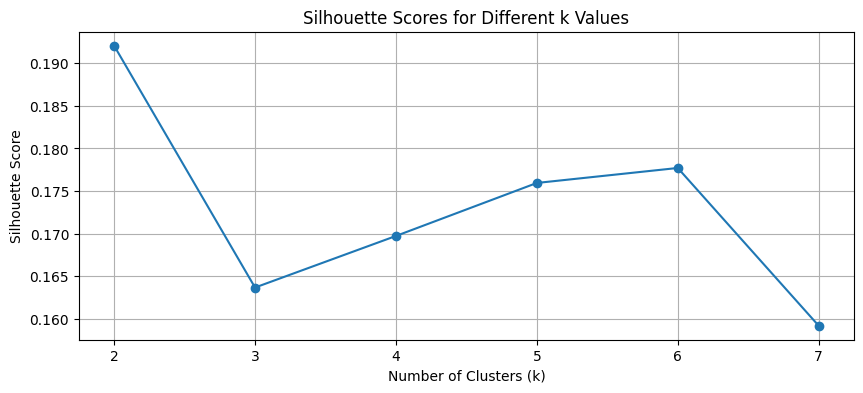

In [26]:
# 사용자 데이터 입력 예시
user_data = {
    'HE_sbp1': 130, 'HE_wc': 85, 'HE_HbA1c': 5.8, 'HE_HDL_st2': 55, 'HE_crea': 0.9, 'age': 60,
    'HE_HP': 2.0, 'sex': 1, 'BS1_1': 3, 'BD1_11': 4
}

# 군집 예측 및 정보 출력
user_cluster, user_df = predict_user_cluster(user_data)

# 실루엣 스코어 플롯 생성
print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
plot_silhouette_scores(df_selected, preprocessor)



그래프 추가

결측값 확인:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64

🔹 사용자가 속한 클러스터: 0
클러스터 이름: 은빛 혈당군
클러스터 요약:
고혈압과 당화혈색소가 높고, 여성 비율이 매우 높은 고령층.
노화와 함께 대사 이상이 진행된 고혈압·당뇨 위험군 여성 중심.


--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---
Silhouette Score for k=2: 0.2503
Silhouette Score for k=3: 0.2236
Silhouette Score for k=4: 0.2163
Silhouette Score for k=5: 0.1805
Silhouette Score for k=6: 0.1755
Silhouette Score for k=7: 0.1713


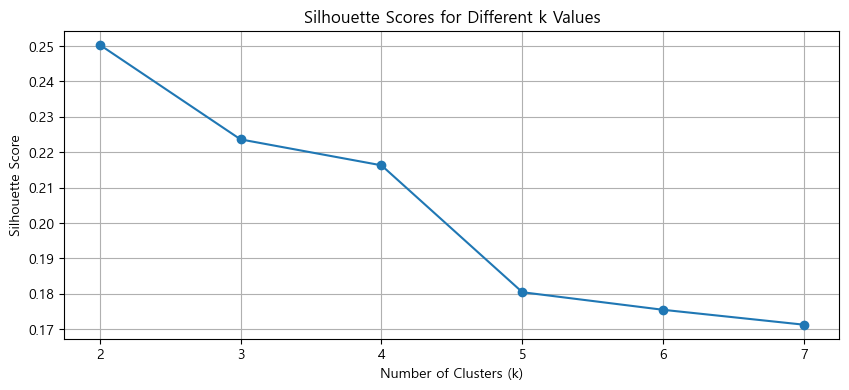


--- Generating Radar Chart ---


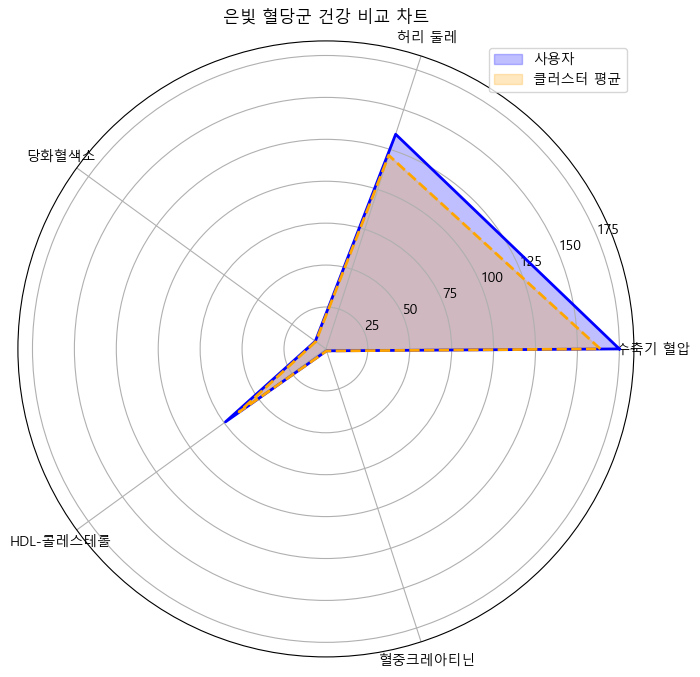

In [37]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer

# --- Matplotlib에서 한글 폰트 설정을 위한 코드 ---
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: Windows 환경의 '맑은 고딕'
# 만약 다른 OS를 사용하거나 해당 폰트가 없으면 다른 한국어 폰트 이름으로 변경해야 합니다.
# 예: macOS의 경우 'AppleGothic', Linux의 경우 'NanumGothic' 등
# 폰트 경로를 직접 지정할 수도 있습니다:
# plt.rcParams['font.family'] = '/path/to/your/korean/font.ttf'

# 마이너스 부호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False

# Load the data
# Replace '선택컬럼_건강데이터.csv' with the actual path to your data file
try:
    df = pd.read_csv('선택컬럼_건강데이터.csv')
except FileNotFoundError:
    print("Error: '선택컬럼_건강데이터.csv' not found. Please provide the correct file path.")
    exit()


# Features to use for clustering
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Separate numeric and categorical features
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11', 'age'] # 'age' is treated as categorical as per your snippet

# Define cluster information and names
cluster_info = {
    0: {
        "name": "은빛 혈당군",
        "summary": "고혈압과 당화혈색소가 높고, 여성 비율이 매우 높은 고령층.\n노화와 함께 대사 이상이 진행된 고혈압·당뇨 위험군 여성 중심."
    },
    1: {
        "name": "불타는 청춘군",
        "summary": "건강 지표는 매우 우수하지만, 음주·흡연 등 생활습관은 다소 좋지 않음.\n젊은 여성 중심으로 건강을 유지 중인 예방적 관리 필요군."
    },
    2: {
        "name": "숨은 콩팥경보군",
        "summary": "중년 남성 중심, 건강 지표는 안정적이나 크레아티닌 수치가 높아 신장 기능 주의 필요.\n생활습관은 양호한 편이지만 잠재적 위험 존재."
    },
    3: {
        "name": "대사 폭풍군",
        "summary": "혈압, 혈당, 복부비만 등 모든 대사 위험 요인이 최고치인 고령 남성.\n대사증후군, 고혈압, 당뇨 고위험군."
    }
}

# Create preprocessing pipelines (including missing value handling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Set up the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Create the full pipeline including preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Select the necessary features from the dataframe
df_selected = df[selected_features].copy()

# Check for missing values (for debugging)
print("결측값 확인:\n", df_selected.isna().sum())

# Perform clustering
# The pipeline handles preprocessing and then clustering
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Calculate mean values per cluster (for visualization)
# Calculate means for all selected features that are numeric *before* one-hot encoding
# This aligns with the radar chart features which are on their original scale
# Ensure all features needed for the radar chart are included here
radar_chart_features_for_means = list(set(numeric_features))
cluster_means_original_scale = df_selected.groupby('Cluster')[radar_chart_features_for_means].mean()


# Function to predict user cluster
def predict_user_cluster(user_data):
    # Convert user data to a DataFrame
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Predict the cluster
    user_cluster = pipeline.predict(user_df)[0]

    # Print cluster information
    print(f"\n🔹 사용자가 속한 클러스터: {user_cluster}")
    print(f"클러스터 이름: {cluster_info[user_cluster]['name']}")
    print(f"클러스터 요약:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# Function to generate silhouette score plot (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    # Apply preprocessing before calculating silhouette scores
    X_processed = preprocessor.fit_transform(df_selected)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Function to generate radar chart comparing user data to cluster average
def plot_radar_chart(user_data, cluster_means_df, user_cluster):
    # Features and labels for the radar chart (matching the image order)
    # Note: Ensure these features are present in your user_data and cluster_means_df
    radar_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea'] 
    radar_labels = ['수축기 혈압','허리 둘레', '당화혈색소', 'HDL-콜레스테롤', '혈중크레아티닌']

    # Extract user values for radar features
    user_values = np.array([user_data.get(feature) for feature in radar_features])

    # Extract cluster average values for radar features
    # Ensure cluster_means_df has the radar_features columns
    if not all(feature in cluster_means_df.columns for feature in radar_features):
        print("Error: Cluster means DataFrame is missing some radar features for plotting.")
        print("Missing features:", [feature for feature in radar_features if feature not in cluster_means_df.columns])
        return

    cluster_avg_values = cluster_means_df.loc[user_cluster, radar_features].values

    # Apply the specific normalization (scaling to 0-175 based on max value)
    # Combine user and cluster values to find the overall max for normalization
    all_values = np.concatenate([user_values, cluster_avg_values])
    max_value = np.nanmax(all_values) # Use nanmax to handle potential NaNs

    # Handle case where max_value is 0 or NaN to avoid division by zero or errors
    if np.isnan(max_value) or max_value == 0:
         user_values_normalized = np.zeros_like(user_values)
         cluster_avg_values_normalized = np.zeros_like(cluster_avg_values)
    else:
        user_values_normalized = (user_values / max_value) * 175
        cluster_avg_values_normalized = (cluster_avg_values / max_value) * 175


    # Radar Chart Generation (in Korean)
    num_vars = len(radar_features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the circle for plotting
    user_values_normalized = np.concatenate((user_values_normalized, [user_values_normalized[0]]))
    cluster_avg_values_normalized = np.concatenate((cluster_avg_values_normalized, [cluster_avg_values_normalized[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, user_values_normalized, color='blue', alpha=0.25, label='사용자')
    ax.plot(angles, user_values_normalized, color='blue', linewidth=2)
    ax.fill(angles, cluster_avg_values_normalized, color='orange', alpha=0.25, label='클러스터 평균')
    ax.plot(angles, cluster_avg_values_normalized, color='orange', linewidth=2, linestyle='--')

    # Set y-ticks based on the normalization scale
    ax.set_yticks([25, 50, 75, 100, 125, 150, 175])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels) # Use Korean labels
    #plt.title(f'클러스터 {int(user_cluster)} 건강 비교 차트') 
    plt.title(f"{cluster_info[user_cluster]['name']} 건강 비교 차트" )
    plt.legend(loc='upper right')
    plt.show()


# --- Example Usage ---

# 사용자 데이터 입력 예시
# Ensure all features used in selected_features and radar_features are included
user_data = {
    'HE_sbp1': 130, 'HE_wc': 100, 'HE_HbA1c': 5.8, 'HE_HDL_st2': 55, 'HE_crea': 0.9, 'age': 30,
    'HE_HP': 2.0, 'sex': 1, 'BS1_1': 3, 'BD1_11': 4,
}

# 군집 예측 및 정보 출력
user_cluster, user_df = predict_user_cluster(user_data)

# 실루엣 스코어 플롯 생성
print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
plot_silhouette_scores(df_selected, preprocessor)

# 레이더 차트 생성
print("\n--- Generating Radar Chart ---")
# Pass the user_data dictionary and the cluster_means_original_scale DataFrame
plot_radar_chart(user_data, cluster_means_original_scale, user_cluster)


그래프 스케일링

결측값 확인:
 HE_sbp1        335
HE_wc          419
HE_HbA1c       764
HE_HDL_st2     745
HE_crea        745
age              0
HE_HP         1122
sex              0
BS1_1            1
BD1_11           1
dtype: int64

🔹 사용자가 속한 클러스터: 0
클러스터 이름: 은빛 혈당군
클러스터 요약:
고혈압과 당화혈색소가 높고, 여성 비율이 매우 높은 고령층.
노화와 함께 대사 이상이 진행된 고혈압·당뇨 위험군 여성 중심.


--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---
Silhouette Score for k=2: 0.2503
Silhouette Score for k=3: 0.2236
Silhouette Score for k=4: 0.2163
Silhouette Score for k=5: 0.1805
Silhouette Score for k=6: 0.1755
Silhouette Score for k=7: 0.1713


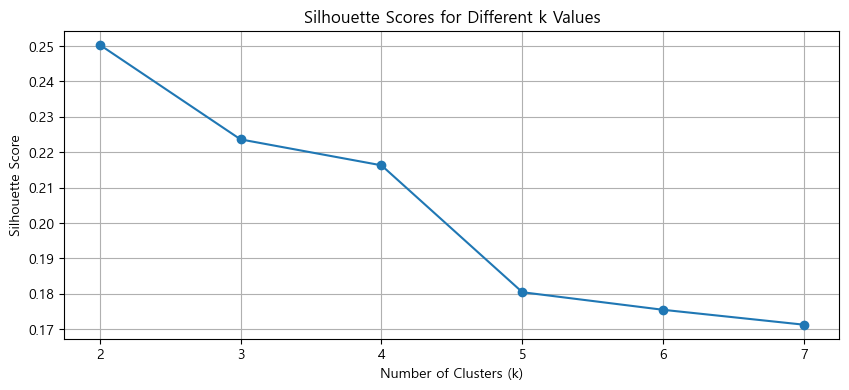


--- Generating Radar Chart ---


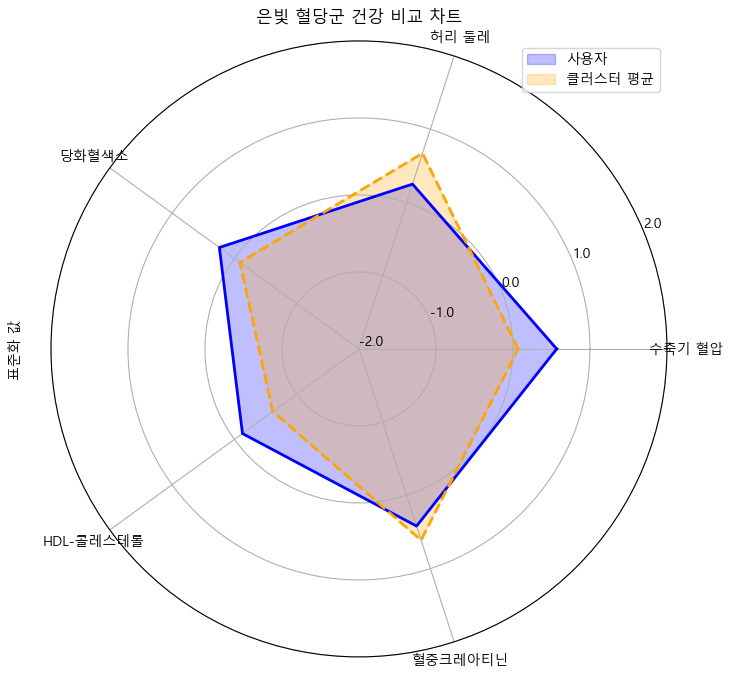

In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer

# --- Matplotlib에서 한글 폰트 설정을 위한 코드 ---
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: Windows 환경의 '맑은 고딕'
# 만약 다른 OS를 사용하거나 해당 폰트가 없으면 다른 한국어 폰트 이름으로 변경해야 합니다.
# 예: macOS의 경우 'AppleGothic', Linux의 경우 'NanumGothic' 등
# 폰트 경로를 직접 지정할 수도 있습니다:
# plt.rcParams['font.family'] = '/path/to/your/korean/font.ttf'

# 마이너스 부호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False
# -------------------------------------------------


# Load the data
# Replace '선택컬럼_건강데이터.csv' with the actual path to your data file
try:
    df = pd.read_csv('선택컬럼_건강데이터.csv')
except FileNotFoundError:
    print("Error: '선택컬럼_건강데이터.csv' not found. Please provide the correct file path.")
    exit()


# Features to use for clustering
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Separate numeric and categorical features
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11', 'age'] # 'age' is treated as categorical as per your snippet

# Define cluster information and names
cluster_info = {
    0: {
        "name": "은빛 혈당군",
        "summary": "고혈압과 당화혈색소가 높고, 여성 비율이 매우 높은 고령층.\n노화와 함께 대사 이상이 진행된 고혈압·당뇨 위험군 여성 중심."
    },
    1: {
        "name": "불타는 청춘군",
        "summary": "건강 지표는 매우 우수하지만, 음주·흡연 등 생활습관은 다소 좋지 않음.\n젊은 여성 중심으로 건강을 유지 중인 예방적 관리 필요군."
    },
    2: {
        "name": "숨은 콩팥경보군",
        "summary": "중년 남성 중심, 건강 지표는 안정적이나 크레아티닌 수치가 높아 신장 기능 주의 필요.\n생활습관은 양호한 편이지만 잠재적 위험 존재."
    },
    3: {
        "name": "대사 폭풍군",
        "summary": "혈압, 혈당, 복부비만 등 모든 대사 위험 요인이 최고치인 고령 남성.\n대사증후군, 고혈압, 당뇨 고위험군."
    }
}

# Create preprocessing pipelines (including missing value handling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Set up the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Create the full pipeline including preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Select the necessary features from the dataframe
df_selected = df[selected_features].copy()

# Check for missing values (for debugging)
print("결측값 확인:\n", df_selected.isna().sum())

# Perform clustering
# The pipeline handles preprocessing and then clustering
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Calculate mean values per cluster (for visualization)
# Calculate means for all selected features that are numeric *before* one-hot encoding
# This aligns with the radar chart features which are on their original scale
# Ensure all features needed for the radar chart are included here
radar_chart_features_for_means = list(set(numeric_features + ['HE_TG', 'HE_LDL_drct', 'HE_chol', 'HE_ast', 'HE_alt', 'HE_wc', 'HE_HDL_st2']))
# Filter out features that are not in the original DataFrame
radar_chart_features_for_means = [feat for feat in radar_chart_features_for_means if feat in df_selected.columns]

cluster_means_original_scale = df_selected.groupby('Cluster')[radar_chart_features_for_means].mean()


# Function to predict user cluster
def predict_user_cluster(user_data):
    # Convert user data to a DataFrame
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Predict the cluster
    user_cluster = pipeline.predict(user_df)[0]

    # Print cluster information
    print(f"\n🔹 사용자가 속한 클러스터: {user_cluster}")
    print(f"클러스터 이름: {cluster_info[user_cluster]['name']}")
    print(f"클러스터 요약:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# Function to generate silhouette score plot (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    # Apply preprocessing before calculating silhouette scores
    X_processed = preprocessor.fit_transform(df_selected)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Function to generate radar chart comparing user data to cluster average
def plot_radar_chart(user_data, cluster_means_df, user_cluster, df_for_scaler):
    # Features and labels for the radar chart
    # Using the features and labels provided in your latest request
    radar_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
    radar_labels = ['수축기 혈압','허리 둘레', '당화혈색소', 'HDL-콜레스테롤', '혈중크레아티닌']

    # Extract user values for radar features into a DataFrame
    # Use .get() with a default of NaN to handle missing features gracefully
    user_df_radar = pd.DataFrame([{feature: user_data.get(feature, np.nan) for feature in radar_features}])

    # Extract cluster average values for radar features into a DataFrame row
    if not all(feature in cluster_means_df.columns for feature in radar_features):
        print("Error: Cluster means DataFrame is missing some radar features for plotting.")
        print("Missing features:", [feature for feature in radar_features if feature not in cluster_means_df.columns])
        return
    cluster_avg_df_radar = pd.DataFrame([cluster_means_df.loc[user_cluster, radar_features].values], columns=radar_features)

    # --- Per-feature Normalization using StandardScaler ---
    # Fit a new scaler specifically on the radar features from the main dataset
    # This ensures scaling is based on the distribution of these features in the data
    scaler_radar = StandardScaler()
    # Fit the scaler on the relevant columns from the original data used for clustering
    scaler_radar.fit(df_for_scaler[radar_features])

    # Transform user data and cluster average data using this new scaler
    # .transform returns a numpy array, [0] is used to get the single row
    user_values_scaled = scaler_radar.transform(user_df_radar)[0]
    cluster_avg_values_scaled = scaler_radar.transform(cluster_avg_df_radar)[0]
    # --- End of Normalization ---


    # Radar Chart Generation (in Korean)
    num_vars = len(radar_features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the circle for plotting by repeating the first value
    user_values_scaled = np.concatenate((user_values_scaled, [user_values_scaled[0]]))
    cluster_avg_values_scaled = np.concatenate((cluster_avg_values_scaled, [cluster_avg_values_scaled[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot data
    ax.fill(angles, user_values_scaled, color='blue', alpha=0.25, label='사용자')
    ax.plot(angles, user_values_scaled, color='blue', linewidth=2)
    ax.fill(angles, cluster_avg_values_scaled, color='orange', alpha=0.25, label='클러스터 평균')
    ax.plot(angles, cluster_avg_values_scaled, color='orange', linewidth=2, linestyle='--')

    # Set y-ticks based on the scaled values (StandardScaler results in mean ~0, std dev ~1)
    # We can set ticks at standard deviation intervals, e.g., -2, 0, 2
    # Determine a reasonable range based on the scaled data
    all_scaled_values = np.concatenate([user_values_scaled[:-1], cluster_avg_values_scaled[:-1]])
    min_scaled = np.nanmin(all_scaled_values)
    max_scaled = np.nanmax(all_scaled_values)

    # Set y-ticks to cover the range, e.g., from min_scaled to max_scaled with a few steps
    # Or use fixed steps like -2, 0, 2 if the scaling is expected to be around that range
    # Let's use a simple approach with a few ticks within a reasonable range for standard scaled data
    y_ticks = np.linspace(min(min_scaled, -2), max(max_scaled, 2), 5) # Example ticks
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in y_ticks]) # Format ticks to one decimal place
    ax.set_ylabel("표준화 값", labelpad=20) # Add a label for the y-axis (scaled value)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels) # Use Korean labels for features

    # Use the cluster name for the title as requested
    plt.title(f"{cluster_info[user_cluster]['name']} 건강 비교 차트" )
    plt.legend(loc='upper right')
    plt.show()


# --- Example Usage ---

# 사용자 데이터 입력 예시
# Ensure all features used in selected_features and radar_features are included
user_data = {
    'HE_sbp1': 130, 'HE_wc': 85, 'HE_HbA1c': 5.8, 'HE_HDL_st2': 55, 'HE_crea': 0.9, 'age': 60,
    'HE_HP': 2.0, 'sex': 1, 'BS1_1': 3, 'BD1_11': 4
}

# 군집 예측 및 정보 출력
user_cluster, user_df = predict_user_cluster(user_data)

# 실루엣 스코어 플롯 생성
print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
plot_silhouette_scores(df_selected, preprocessor)

# 레이더 차트 생성
print("\n--- Generating Radar Chart ---")
# Pass the user_data dictionary, the cluster_means_original_scale DataFrame,
# the user_cluster, and the df_selected (to fit the scaler)
plot_radar_chart(user_data, cluster_means_original_scale, user_cluster, df_selected)


최종

클러스터 이름: 대사 폭풍군
클러스터 요약:
혈압, 혈당, 복부비만 등 모든 대사 위험 요인이 최고치인 고령 남성층.
대사증후군, 고혈압, 당뇨 고위험군.


--- Generating Radar Chart ---


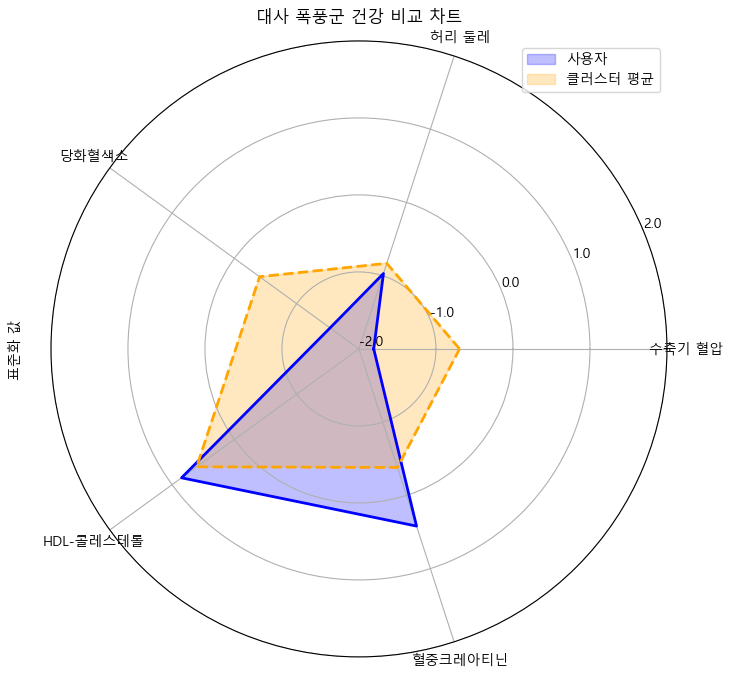

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.impute import SimpleImputer

# --- Matplotlib에서 한글 폰트 설정을 위한 코드 ---
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: Windows 환경의 '맑은 고딕'
# 만약 다른 OS를 사용하거나 해당 폰트가 없으면 다른 한국어 폰트 이름으로 변경해야 합니다.
# 예: macOS의 경우 'AppleGothic', Linux의 경우 'NanumGothic' 등
# 폰트 경로를 직접 지정할 수도 있습니다:
# plt.rcParams['font.family'] = '/path/to/your/korean/font.ttf'

# 마이너스 부호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False
# -------------------------------------------------


# Load the data
# Replace '선택컬럼_건강데이터.csv' with the actual path to your data file
try:
    df = pd.read_csv('선택컬럼_건강데이터.csv')
except FileNotFoundError:
    print("Error: '선택컬럼_건강데이터.csv' not found. Please provide the correct file path.")
    exit()


# Features to use for clustering
selected_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea', 'age', 'HE_HP', 'sex', 'BS1_1', 'BD1_11']

# Separate numeric and categorical features
numeric_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
categorical_features = ['HE_HP', 'sex', 'BS1_1', 'BD1_11', 'age'] # 'age' is treated as categorical as per your snippet

# Define cluster information and names
cluster_info = {
    0: {
        "name": "은빛 혈당군",
        "summary": "고혈압과 당화혈색소가 높고, 여성 비율이 매우 높은 고령층.\n노화와 함께 대사 이상이 진행된 고혈압·당뇨 위험군"
    },
    1: {
        "name": "불타는 청춘군",
        "summary": "건강 지표는 매우 우수하지만, 음주·흡연 등 생활습관은 다소 좋지 않음.\n젊은 여성 중심으로 건강을 유지 중인 예방적 관리 필요군."
    },
    2: {
        "name": "숨은 콩팥경보군",
        "summary": "중년 남성 중심, 건강 지표는 안정적이나 크레아티닌 수치가 높아 신장 기능 주의 필요.\n생활습관은 양호한 편이지만 잠재적 위험 존재."
    },
    3: {
        "name": "대사 폭풍군",
        "summary": "혈압, 혈당, 복부비만 등 모든 대사 위험 요인이 최고치인 고령 남성층.\n대사증후군, 고혈압, 당뇨 고위험군."
    }
}

# Create preprocessing pipelines (including missing value handling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Set up the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Create the full pipeline including preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', kmeans)
])

# Select the necessary features from the dataframe
df_selected = df[selected_features].copy()

# Check for missing values (for debugging)
#print("결측값 확인:\n", df_selected.isna().sum())

# Perform clustering
# The pipeline handles preprocessing and then clustering
df_selected['Cluster'] = pipeline.fit_predict(df_selected)

# Calculate mean values per cluster (for visualization)
# Calculate means for all selected features that are numeric *before* one-hot encoding
# This aligns with the radar chart features which are on their original scale
# Ensure all features needed for the radar chart are included here
radar_chart_features_for_means = list(set(numeric_features + ['HE_TG', 'HE_LDL_drct', 'HE_chol', 'HE_ast', 'HE_alt', 'HE_wc', 'HE_HDL_st2']))
# Filter out features that are not in the original DataFrame
radar_chart_features_for_means = [feat for feat in radar_chart_features_for_means if feat in df_selected.columns]

cluster_means_original_scale = df_selected.groupby('Cluster')[radar_chart_features_for_means].mean()


# Function to predict user cluster
def predict_user_cluster(user_data):
    # Convert user data to a DataFrame
    user_df = pd.DataFrame([user_data], columns=selected_features)

    # Predict the cluster
    user_cluster = pipeline.predict(user_df)[0]

    # Print cluster information
    #print(f"\n🔹 사용자가 속한 클러스터: {user_cluster}")
    print(f"클러스터 이름: {cluster_info[user_cluster]['name']}")
    print(f"클러스터 요약:\n{cluster_info[user_cluster]['summary']}\n")

    return user_cluster, user_df

# Function to generate silhouette score plot (k=2~8)
def plot_silhouette_scores(df_selected, preprocessor):
    silhouette_scores = []
    k_range = range(2, 8)

    # Apply preprocessing before calculating silhouette scores
    X_processed = preprocessor.fit_transform(df_selected)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        pipeline_temp = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('clusterer', kmeans)
        ])
        labels = pipeline_temp.fit_predict(df_selected)
        score = silhouette_score(preprocessor.fit_transform(df_selected), labels)
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.4f}")

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Function to generate radar chart comparing user data to cluster average
def plot_radar_chart(user_data, cluster_means_df, user_cluster, df_for_scaler):
    # Features and labels for the radar chart
    # Using the features and labels provided in your latest request
    radar_features = ['HE_sbp1', 'HE_wc', 'HE_HbA1c', 'HE_HDL_st2', 'HE_crea']
    radar_labels = ['수축기 혈압','허리 둘레', '당화혈색소', 'HDL-콜레스테롤', '혈중크레아티닌']

    # Extract user values for radar features into a DataFrame
    # Use .get() with a default of NaN to handle missing features gracefully
    user_df_radar = pd.DataFrame([{feature: user_data.get(feature, np.nan) for feature in radar_features}])

    # Extract cluster average values for radar features into a DataFrame row
    if not all(feature in cluster_means_df.columns for feature in radar_features):
        print("Error: Cluster means DataFrame is missing some radar features for plotting.")
        print("Missing features:", [feature for feature in radar_features if feature not in cluster_means_df.columns])
        return
    cluster_avg_df_radar = pd.DataFrame([cluster_means_df.loc[user_cluster, radar_features].values], columns=radar_features)

    # --- Per-feature Normalization using StandardScaler ---
    # Fit a new scaler specifically on the radar features from the main dataset
    # This ensures scaling is based on the distribution of these features in the data
    scaler_radar = StandardScaler()
    # Fit the scaler on the relevant columns from the original data used for clustering
    scaler_radar.fit(df_for_scaler[radar_features])

    # Transform user data and cluster average data using this new scaler
    # .transform returns a numpy array, [0] is used to get the single row
    user_values_scaled = scaler_radar.transform(user_df_radar)[0]
    cluster_avg_values_scaled = scaler_radar.transform(cluster_avg_df_radar)[0]
    # --- End of Normalization ---


    # Radar Chart Generation (in Korean)
    num_vars = len(radar_features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the circle for plotting by repeating the first value
    user_values_scaled = np.concatenate((user_values_scaled, [user_values_scaled[0]]))
    cluster_avg_values_scaled = np.concatenate((cluster_avg_values_scaled, [cluster_avg_values_scaled[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot data
    ax.fill(angles, user_values_scaled, color='blue', alpha=0.25, label='사용자')
    ax.plot(angles, user_values_scaled, color='blue', linewidth=2)
    ax.fill(angles, cluster_avg_values_scaled, color='orange', alpha=0.25, label='클러스터 평균')
    ax.plot(angles, cluster_avg_values_scaled, color='orange', linewidth=2, linestyle='--')

    # Set y-ticks based on the scaled values (StandardScaler results in mean ~0, std dev ~1)
    # We can set ticks at standard deviation intervals, e.g., -2, 0, 2
    # Determine a reasonable range based on the scaled data
    all_scaled_values = np.concatenate([user_values_scaled[:-1], cluster_avg_values_scaled[:-1]])
    min_scaled = np.nanmin(all_scaled_values)
    max_scaled = np.nanmax(all_scaled_values)

    # Set y-ticks to cover the range, e.g., from min_scaled to max_scaled with a few steps
    # Or use fixed steps like -2, 0, 2 if the scaling is expected to be around that range
    # Let's use a simple approach with a few ticks within a reasonable range for standard scaled data
    y_ticks = np.linspace(min(min_scaled, -2), max(max_scaled, 2), 5) # Example ticks
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in y_ticks]) # Format ticks to one decimal place
    ax.set_ylabel("표준화 값", labelpad=20) # Add a label for the y-axis (scaled value)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels) # Use Korean labels for features

    # Use the cluster name for the title as requested
    plt.title(f"{cluster_info[user_cluster]['name']} 건강 비교 차트" )
    plt.legend(loc='upper right')
    plt.show()


# --- Example Usage ---

# 사용자 데이터 입력 예시
user_data_for_cluster_1 = {
  'HE_sbp1': 110,   # 혈압
  'HE_wc': 70,      # 허리둘레
  'HE_HbA1c': 5.2,  # 당화혈색소
  'HE_HDL_st2': 80, # HDL 콜레스테롤
  'HE_crea': 0.6,   # 크레아티닌
  'age': 15,      # 나이
  'HE_HP': 1,     # 고혈압 유병 여부
  'sex': 1,       # 여성 
  'BS1_1': 2,     # 평생 흡연 
  'BD1_11': 5     # 1년 간 음주빈도
}

# 군집 예측 및 정보 출력
user_cluster, user_df = predict_user_cluster(user_data)

# 실루엣 스코어 플롯 생성
#print("\n--- Visualizing Silhouette Scores for k in [2, 3, ..., 10] ---")
#plot_silhouette_scores(df_selected, preprocessor)

# 레이더 차트 생성
print("\n--- Generating Radar Chart ---")
# Pass the user_data dictionary, the cluster_means_original_scale DataFrame,
# the user_cluster, and the df_selected (to fit the scaler)
plot_radar_chart(user_data, cluster_means_original_scale, user_cluster, df_selected)


전처리 다시

In [ ]:
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv('선택컬럼_건강데이터.csv')

# 결측치 확인
print("NaN 결측치 개수:")
print(df.isna().sum())

# 특수 값 확인
special_values = [8, 9, 88, 99, 888, 999]
print("\n특수 값(8, 9, 88, 99, 888, 999) 빈도:")
for col in df.columns:
    # 해당 열에서 special_values에 포함된 값만 필터링
    value_counts = df[col].value_counts()
    special_counts = value_counts[value_counts.index.isin(special_values)]
    if not special_counts.empty:
        print(f"{col}:")
        print(special_counts)
        print()


NaN 결측치 개수:
ID            0
year          0
region        0
town_t        0
sex           0
           ... 
L_LN_FQ     132
L_DN_FQ     132
L_OUT_FQ    132
LS_VEG1     132
LS_FRUIT    132
Length: 98, dtype: int64

특수 값(8, 9, 88, 99, 888, 999) 빈도:
region:
region
9.0    1742
8.0     147
Name: count, dtype: int64

age:
age
9.0    69
8.0    64
Name: count, dtype: int64

D_1_1:
D_1_1
9.0    487
Name: count, dtype: int64

DI1_dg:
DI1_dg
8.0    1022
Name: count, dtype: int64

DI1_ag:
DI1_ag
888.0    5246
999.0      17
Name: count, dtype: int64

DI1_pr:
DI1_pr
8.0    5246
Name: count, dtype: int64

DI1_pt:
DI1_pt
8.0    5246
Name: count, dtype: int64

DI1_2:
DI1_2
8.0    5246
Name: count, dtype: int64

DI2_dg:
DI2_dg
8.0    1022
Name: count, dtype: int64

DI2_ag:
DI2_ag
888.0    5318
999.0       8
Name: count, dtype: int64

DI2_pr:
DI2_pr
8.0    5318
Name: count, dtype: int64

DI2_pt:
DI2_pt
8.0    5318
Name: count, dtype: int64

DI2_2:
DI2_2
8.0    5318
Name: count, dtype: int64

DE1_dg:
DE1_

In [13]:
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv('선택컬럼_건강데이터.csv')

# 연속형 피처 선택 (수치형: float64, int64)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# region과 age 포함
selected_cols = list(numeric_cols)  # 연속형 피처
if 'region' not in selected_cols:
    selected_cols.append('region')
if 'age' not in selected_cols:
    selected_cols.append('age')

# 선택된 피처로 데이터프레임 필터링
df_selected = df[selected_cols]

# 특수 값 처리
# 1. DI1_pr, DI1_2, DI2_pr, DI2_2, DE1_dg, DN1_dg, BO1, BO2_1, BD1_11, BP1, BP5, BE5_1
#    -> 8, 9, 88, 99, 888, 999를 NaN으로 변환
cols_full_replace = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1']
df_selected[cols_full_replace] = df_selected[cols_full_replace].replace([8, 9, 88, 99, 888, 999], np.nan)

# 2. BS3_2 -> 888만 NaN으로 변환
df_selected['BS3_2'] = df_selected['BS3_2'].replace(888, np.nan)

# 3. BE3_31 -> 88, 99만 NaN으로 변환
df_selected['BE3_31'] = df_selected['BE3_31'].replace([88, 99], np.nan)

# 변환 후 결측치 확인
print("특수 값 변환 후 결측치 개수:")
print(df_selected.isna().sum())

# 선택된 피처 목록 출력
print("\n선택된 피처:")
print(df_selected.columns.tolist())

# 데이터프레임 저장 (필요 시)
df_selected.to_csv('processed_health_data.csv', index=False)
print("\n처리된 데이터가 'processed_health_data.csv'로 저장되었습니다.")

특수 값 변환 후 결측치 개수:
year          0
region        0
town_t        0
sex           0
age           0
           ... 
L_LN_FQ     132
L_DN_FQ     132
L_OUT_FQ    132
LS_VEG1     132
LS_FRUIT    132
Length: 97, dtype: int64

선택된 피처:
['year', 'region', 'town_t', 'sex', 'age', 'incm', 'ho_incm', 'edu', 'occp', 'cfam', 'genertn', 'D_1_1', 'DI1_dg', 'DI1_ag', 'DI1_pr', 'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2', 'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32', 'DE1_33', 'DE1_34', 'DE1_4', 'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1', 'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2', 'BP1', 'BP5', 'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1', 'BS12_2', 'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'HE_fh', 'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_DMfh1', 'HE_DMfh2', 'HE_sbp1', 'HE_dbp1', 'HE_sbp2', 'HE_dbp2', 'HE_HP', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI', 'HE_obe', 'HE_glu', 'HE_HbA1c', 'HE_DM_HbA1c', 'HE_chol', 'H

C:\Users\asia\AppData\Local\Temp\ipykernel_11528\2244195498.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[cols_full_replace] = df_selected[cols_full_replace].replace([8, 9, 88, 99, 888, 999], np.nan)
C:\Users\asia\AppData\Local\Temp\ipykernel_11528\2244195498.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['BS3_2'] = df_selected['BS3_2'].replace(888, np.nan)
C:\Users\asia\AppData\Local\Temp\ipykernel_11528\2244195498.py:31: SettingWithCopyWarning: 
A value is trying to be

In [21]:
missing_ratio = df.isna().mean()
print("결측치 비율:")
print(missing_ratio[missing_ratio > 0])

df = df.loc[:, missing_ratio < 0.3] #결측치 비율이 높은 열 (예: 30% 이상): 군집화에 유의미한 정보를 제공하지 않을 가능성이 높으므로 삭제.
df.columns


결측치 비율:
Series([], dtype: float64)


Index(['ID', 'year', 'region', 'town_t', 'sex', 'age', 'incm', 'ho_incm',
       'edu', 'occp', 'cfam', 'genertn', 'D_1_1', 'DI1_dg', 'DI1_ag', 'DI1_pr',
       'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2',
       'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32',
       'DE1_33', 'DE1_34', 'DE1_4', 'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1',
       'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2', 'BP1', 'BP5',
       'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1',
       'BS12_2', 'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'HE_fh',
       'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_DMfh1', 'HE_DMfh2',
       'HE_sbp1', 'HE_dbp1', 'HE_sbp2', 'HE_dbp2', 'HE_HP', 'HE_ht', 'HE_wt',
       'HE_wc', 'HE_BMI', 'HE_obe', 'HE_glu', 'HE_HbA1c', 'HE_DM_HbA1c',
       'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct', 'HE_HCHOL', 'HE_HTG',
       'HE_ast', 'HE_alt', 'HE_BUN', 'HE_crea', 'HE_Upro', 'HE_Ucrea',
       'HE

In [22]:
df.dtypes

ID           object
year        float64
region      float64
town_t      float64
sex         float64
             ...   
L_LN_FQ     float64
L_DN_FQ     float64
L_OUT_FQ    float64
LS_VEG1     float64
LS_FRUIT    float64
Length: 98, dtype: object

In [24]:
all_columns = df.columns.tolist()
num_columns = df._get_numeric_data().columns.tolist()
cat_columns = list(set(all_columns) - set(num_columns))

print(f'모든 컬럼은 아래와 같습니다. \n{all_columns}\n')
print(f'수치형 컬럼은 아래와 같습니다. \n{num_columns}\n')
print(f'범주형 컬럼은 아래와 같습니다. \n{cat_columns}\n')

모든 컬럼은 아래와 같습니다. 
['ID', 'year', 'region', 'town_t', 'sex', 'age', 'incm', 'ho_incm', 'edu', 'occp', 'cfam', 'genertn', 'D_1_1', 'DI1_dg', 'DI1_ag', 'DI1_pr', 'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2', 'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32', 'DE1_33', 'DE1_34', 'DE1_4', 'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1', 'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2', 'BP1', 'BP5', 'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1', 'BS12_2', 'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'HE_fh', 'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_DMfh1', 'HE_DMfh2', 'HE_sbp1', 'HE_dbp1', 'HE_sbp2', 'HE_dbp2', 'HE_HP', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI', 'HE_obe', 'HE_glu', 'HE_HbA1c', 'HE_DM_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct', 'HE_HCHOL', 'HE_HTG', 'HE_ast', 'HE_alt', 'HE_BUN', 'HE_crea', 'HE_Upro', 'HE_Ucrea', 'HE_Ualb', 'L_BR_FQ', 'L_LN_FQ', 'L_DN_FQ', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT']

수치

In [ ]:
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv('선택컬럼_건강데이터.csv')

# Columns to drop
drop_columns = ['ID', 'year']
df = df.drop(columns=drop_columns)

# Define numeric columns explicitly
numeric_cols = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol',
    'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    'HE_wt', 'HE_ht', 'HE_BMI'
]

# Create list of categorical columns by excluding numeric columns
categorical_cols = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2','BE3_31']

# Print for confirmation
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI']
Categorical columns: ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']


In [42]:
from sklearn.impute import KNNImputer #수치형 변수 knn으로 대체
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [43]:
print(df[numeric_cols].isna().sum()) #연속형 변수 처리 확인

HE_sbp1        0
HE_dbp1        0
HE_wc          0
HE_glu         0
HE_HbA1c       0
HE_chol        0
HE_HDL_st2     0
HE_LDL_drct    0
HE_crea        0
HE_ast         0
HE_alt         0
HE_wt          0
HE_ht          0
HE_BMI         0
dtype: int64


In [ ]:
ols_full_replace = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', #범주형 변수 888 이런 거 처리
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1']
df[cols_full_replace] = df[cols_full_replace].replace([8, 9, 88, 99, 888, 999], np.nan)

# 2. BS3_2 -> 888만 NaN으로 변환
df['BS3_2'] = df['BS3_2'].replace(888, np.nan)

# 3. BE3_31 -> 88, 99만 NaN으로 변환
df['BE3_31'] = df['BE3_31'].replace([88, 99], np.nan)

In [55]:
import numpy as np
import pandas as pd


# 결측치를 대체할 범주형 피처 목록
categorical_cols = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2','BE3_31']

# 그룹화 기준 컬럼
group_cols = ['sex', 'age']

print("원본 데이터프레임 (결측치 포함):")
print(df[categorical_cols].head())
print("\n원본 데이터프레임 결측치 개수:")
print(df[categorical_cols].isna().sum())

# 그룹별 평균으로 결측치 대체
for col in categorical_cols:
    # 그룹별 평균 계산 (결측치가 있는 그룹은 NaN이 될 수 있음)
    group_means = df.groupby(group_cols)[col].transform('mean')

    # 그룹별 평균으로 결측치 대체
    df[col] = df[col].fillna(group_means)

    # 그룹별 평균으로도 채워지지 않은 결측치 (그룹 내 모든 값이 NaN이었던 경우)를 전체 평균으로 대체
    if df[col].isna().any():
        overall_mean = df[col].mean()
        df[col] = df[col].fillna(overall_mean)

print("\n결측치 대체 후 데이터프레임:")
print(df[categorical_cols].head())
print("\n결측치 대체 후 결측치 개수:")
print(df[categorical_cols].isna().sum())

원본 데이터프레임 (결측치 포함):
     DI1_pr     DI1_2    DI2_pr     DI2_2  DE1_dg  DN1_dg  BO1  BO2_1  \
0  1.000000  1.000000  1.000000  1.000000     0.0     0.0  3.0    2.0   
1  0.960000  1.160000  1.000000  1.000000     0.0     0.0  2.0    3.0   
2  1.000000  1.000000  1.000000  1.000000     0.0     0.0  3.0    1.0   
3       NaN       NaN       NaN       NaN     NaN     NaN  4.0    1.0   
4  0.833333  1.666667  0.857143  2.142857     0.0     0.0  3.0    4.0   

     BD1_11  BP1  BP5  BE5_1       BS3_2  BE3_31  
0  3.500000  3.0  2.0    6.0  174.833333     8.0  
1  2.181818  3.0  1.0    1.0  667.666667     4.0  
2  5.000000  3.0  2.0    1.0  667.000000     8.0  
3       NaN  NaN  NaN    NaN         NaN     NaN  
4  4.000000  3.0  2.0    1.0   12.652174     1.0  

원본 데이터프레임 결측치 개수:
DI1_pr    1941
DI1_2     1941
DI2_pr    1794
DI2_2     1794
DE1_dg    1022
DN1_dg    1022
BO1        221
BO2_1      221
BD1_11     724
BP1        629
BP5        629
BE5_1      629
BS3_2     1108
BE3_31    1022
dtype:

In [56]:
# 데이터프레임 저장 (필요 시)
df.to_csv('processed_health_data.csv', index=False)
print("\n처리된 데이터가 'processed_health_data.csv'로 저장되었습니다.")


처리된 데이터가 'processed_health_data.csv'로 저장되었습니다.


In [59]:
df = pd.read_csv('processed_health_data.csv')
print(df.columns.isna().sum())

0


Data loaded. Shape: (6929, 96)

Numeric columns found in data: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_BMI', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns found in data: ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']
Removed highly correlated numeric features (>0.8): ['HE_LDL_drct', 'HE_alt', 'HE_BMI']
Selected numeric features after correlation check: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']

Initial features for clustering (25): ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1', 'DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 

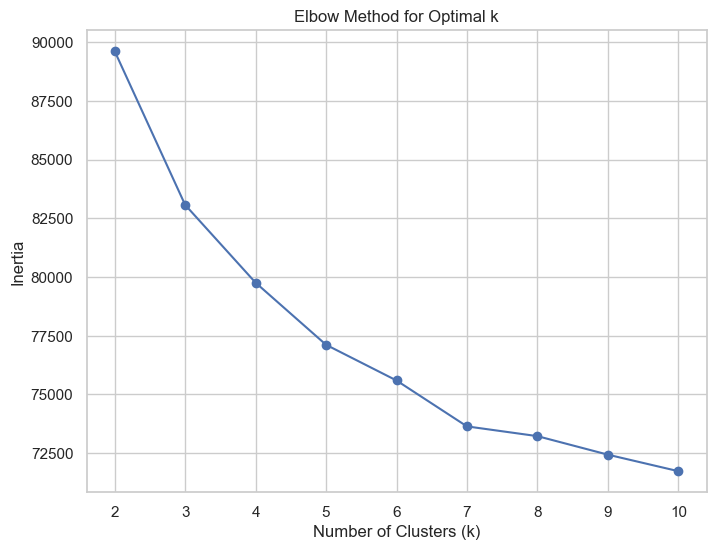


--- Visualizing Silhouette Scores for k in [2, 3, 4, 5, 6, 7, 8, 9, 10] ---


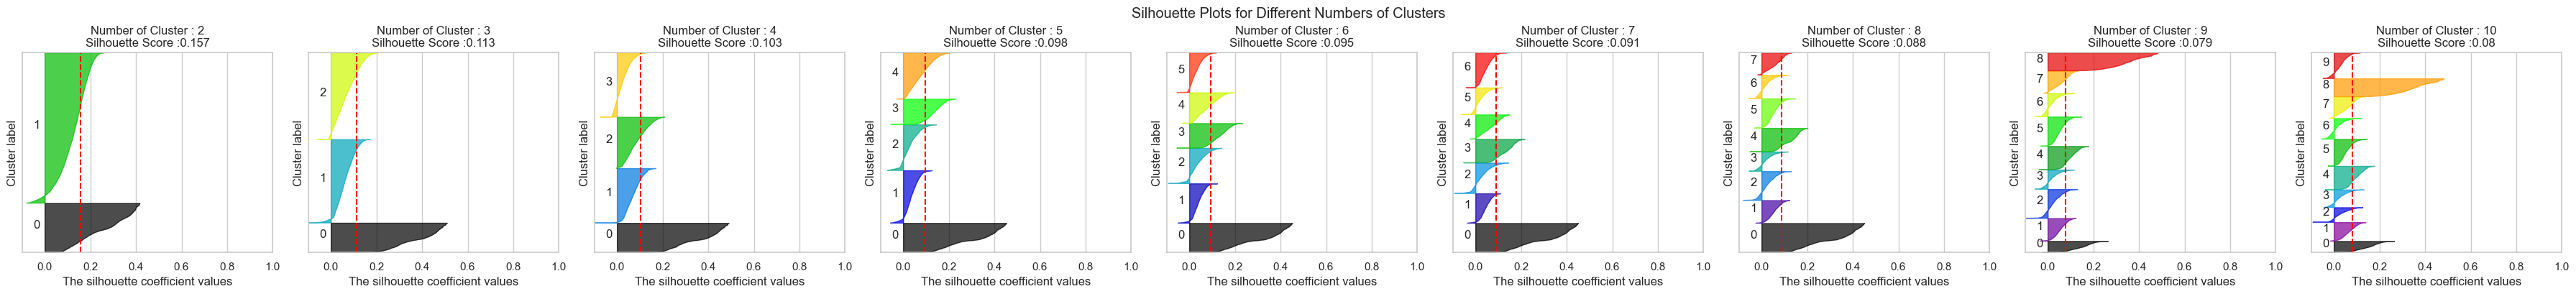


>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<
>>> Currently using optimal_k = 4 (example value). <<<

=== Iteration 1: Baseline Clustering (KMeans, k=4) ===

--- Running Iteration with 25 features ---

--- Preprocessing ---
Numeric columns in current df: ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_crea', 'HE_ast', 'age', 'L_OUT_FQ', 'LS_VEG1']
Categorical columns in current df: ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2', 'BE3_31']
Shape after preprocessing (scaled and OHE): (6929, 967)
PCA reduced dimensions to: 127
Explained variance ratio: 0.9503

--- Running KMeans (k=4) ---
KMeans (k=4): Silhouette Score = 0.1028

Feature Importance (Random Forest) for non-noise clusters:
age           0.148681
HE_HbA1c      0.095638
HE_chol       0.094191
DE1_dg        0.085090
HE_wc         0.075897
HE_sbp1       0.072342
HE_dbp1       0.064199
DI2_2         0.05

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트
from scipy import stats
import statsmodels.api as sm # 카이제곱 검정 결과를 좀 더 상세히 보여주기 위해 추가 (Optional)
from statsmodels.stats.contingency_tables import Table # 카이제곱 검정을 위한 클래스

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이전 코드와 동일)
def preprocess_data(df, original_numeric_cols, original_categorical_cols):
    """
    Preprocess data: impute missing values, handle outliers, encode categorical features.
    Processes only the columns present in the input df, based on original_numeric_cols and original_categorical_cols.
    """
    df_processed = df.copy()

    current_numeric_cols = [col for col in original_numeric_cols if col in df_processed.columns]
    current_categorical_cols = [col for col in original_categorical_cols if col in df_processed.columns]

    print(f"\n--- Preprocessing ---")
    print(f"Numeric columns in current df: {current_numeric_cols}")
    print(f"Categorical columns in current df: {current_categorical_cols}")

    # 888, 999 값을 NaN으로 대체
    df_processed = df_processed.replace([888, 999], np.nan)

    # 숫자형 칼럼 결측치 KNN Imputer로 처리
    if current_numeric_cols:
        # Imputer는 fit_transform 시점에 결측치를 학습하고 채웁니다.
        # 이 함수는 매번 새로운 Imputer를 생성하여 fit_transform 합니다.
        # 만약 일관된 Imputer를 사용하려면 함수 외부에서 fit 된 Imputer를 전달해야 합니다.
        # 현재 코드 흐름 상 그룹별/피처셋별로 다른 Imputer가 필요할 수 있으므로 이 방식 유지
        numeric_data_for_impute = df_processed[current_numeric_cols].values
        imputer = KNNImputer(n_neighbors=5)
        numeric_data_imputed = imputer.fit_transform(numeric_data_for_impute)
        df_processed[current_numeric_cols] = numeric_data_imputed

    # 범주형 칼럼 결측치 최빈값으로 처리
    if current_categorical_cols:
        for col in current_categorical_cols:
             if df_processed[col].isnull().any():
                 try:
                     # mode() 결과는 Series이므로 [0]으로 첫 번째 값 선택
                     mode_val = df_processed[col].mode()[0]
                     df_processed[col] = df_processed[col].fillna(mode_val)
                 except IndexError:
                     # mode()가 비어있는 경우 (모든 값이 NaN일 때)
                     print(f"Warning: Could not compute mode for {col} or all values are NaN. Skipping fillna for this column.")
                     pass # fillna를 건너뛰어 해당 칼럼은 여전히 NaN을 가질 수 있음 (주의 필요)
                 except Exception as e:
                     print(f"Error filling categorical missing values for {col}: {e}")
                     pass


    # 이상치 처리 (IQR 기준) - 숫자형 칼럼에만 적용
    if current_numeric_cols:
        for col in current_numeric_cols:
            # IQR 계산
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            # 이상치 경계 계산
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # 이상치 값을 경계값으로 대체 (클리핑)
            df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)

    # 전처리를 위한 ColumnTransformer 설정
    transformers = []
    if current_numeric_cols:
        # 숫자형 칼럼에 RobustScaler 적용 (이상치에 강함)
        transformers.append(('num', RobustScaler(), current_numeric_cols))
    if current_categorical_cols:
        # 범주형 칼럼에 OneHotEncoder 적용
        # handle_unknown='ignore': 학습 데이터에 없던 새로운 범주가 예측 시 나타나면 무시
        transformers.append(('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), current_categorical_cols))

    # 변환할 칼럼이 없으면 빈 데이터프레임 반환
    if not transformers:
        print("No numeric or categorical columns remaining after filtering.")
        # scaled_df, all_transformed_features, preprocessor, df_processed_subset 반환
        return pd.DataFrame(), [], None, df_processed

    # ColumnTransformer 생성 및 학습/변환
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough' # 변환기에 지정되지 않은 칼럼은 그대로 유지
    )

    try:
        # preprocessor를 데이터에 fit_transform 합니다.
        scaled_data = preprocessor.fit_transform(df_processed)
        # 변환 후 칼럼 이름 가져오기
        all_transformed_features = preprocessor.get_feature_names_out()
        # 변환된 데이터를 DataFrame으로 변환 (칼럼 이름 포함)
        scaled_df = pd.DataFrame(scaled_data, columns=all_transformed_features)
        print(f"Shape after preprocessing (scaled and OHE): {scaled_df.shape}")
    except Exception as e:
        print(f"Error during preprocessing transformation: {e}")
        # 오류 발생 시 빈 데이터프레임 등 반환
        return pd.DataFrame(), [], None, df_processed

    # 전처리된 스케일링/OHE 데이터, 변환된 피처 이름 목록, 학습된 preprocessor 객체, 이상치/결측치 처리된 원본 형태 데이터 반환
    return scaled_df, all_transformed_features, preprocessor, df_processed

# select_features 함수 (이전 코드와 동일)
def select_features(df, columns, corr_threshold=0.8):
    """Remove highly correlated numeric features."""
    # 입력된 칼럼 목록 중 숫자형 칼럼만 선택
    numeric_df = df[columns].select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns provided for correlation check.")
        return [] # 숫자형 칼럼이 없으면 빈 리스트 반환

    # 상관 행렬 계산 (절대값 사용)
    corr_matrix = numeric_df.corr().abs()
    # 상관 행렬의 상삼각 행렬만 가져옴 (대각선 제외)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # 상관계수가 임계값보다 높은 칼럼들을 찾음
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    # 제거할 칼럼을 제외한 숫자형 칼럼 목록 생성
    selected_numeric_cols = [col for col in columns if col not in to_drop]
    print(f"Removed highly correlated numeric features (>{corr_threshold}): {to_drop}")
    print(f"Selected numeric features after correlation check: {selected_numeric_cols}")
    return selected_numeric_cols # 상관관계 필터링 후 숫자형 칼럼 목록 반환

# compute_feature_importance 함수 (이전 코드와 동일)
def compute_feature_importance(df_processed, selected_cols, cluster_labels):
    """Compute feature importance using Random Forest."""
    # 클러스터 라벨이 2개 이상이고 노이즈 클러스터(-1)만 있는 경우가 아닐 때만 중요도 계산
    if len(np.unique(cluster_labels[cluster_labels != -1])) < 2:
        print("\nFeature Importance: Not enough non-noise clusters (>= 2 required) or only noise cluster.")
        return pd.Series([], dtype=float) # 계산 불가 시 빈 Series 반환

    # 노이즈 클러스터(-1)에 해당하는 데이터 포인트 제외
    non_noise_indices = cluster_labels != -1
    df_filtered = df_processed.loc[non_noise_indices].copy() # 필터링된 데이터 복사
    labels_filtered = cluster_labels[non_noise_indices] # 필터링된 라벨

    # 필터링 후 데이터가 비어있으면 계산 불가
    if df_filtered.empty:
        print("\nFeature Importance: No non-noise data points found after filtering.")
        return pd.Series([], dtype=float) # 계산 불가 시 빈 Series 반환

    try:
        # Random Forest Classifier 모델 생성 및 학습
        rf = RandomForestClassifier(random_state=42)
        # 학습 데이터는 필터링된 데이터와 해당 피처들, 필터링된 라벨 사용
        # df_filtered는 이상치/결측치 처리된 원본 형태의 데이터프레임입니다.
        # OHE된 데이터가 필요하다면 scaled_df를 사용해야 합니다.
        # 현재 코드는 df_processed_subset (이상치/결측치 처리된 원본 형태)를 사용합니다.
        # 만약 OHE된 데이터로 중요도를 계산하려면 scaled_df와 all_transformed_features를 사용하도록 수정 필요.
        # 여기서는 기존 코드대로 df_processed_subset을 사용합니다.
        rf.fit(df_filtered[selected_cols], labels_filtered)
        # 피처 중요도 추출 및 Series로 변환 후 내림차순 정렬
        importance = pd.Series(rf.feature_importances_, index=selected_cols).sort_values(ascending=False)
        print("\nFeature Importance (Random Forest) for non-noise clusters:")
        print(importance)
        return importance # 피처 중요도 Series 반환

    except Exception as e:
        print(f"\nError computing Feature Importance: {e}")
        return pd.Series([], dtype=float) # 오류 발생 시 빈 Series 반환

# visualize_silhouette 함수 (이전 코드와 동일)
def visualize_silhouette(cluster_lists, X_features):
    """
    주어진 클러스터 개수 리스트에 대해 K-Means를 적용하고 실루엣 계수를 시각화합니다.

    Args:
        cluster_lists (list): 테스트할 클러스터 개수(k)의 리스트.
        X_features (numpy.ndarray or pandas.DataFrame): 클러스터링 대상 데이터 (PCA 결과 등).
    """
    print(f"\n--- Visualizing Silhouette Scores for k in {cluster_lists} ---")

    n_cols = len(cluster_lists)
    # 서브플롯 생성. n_cols가 1일 때 axs가 배열이 아니므로 reshape(-1)로 항상 배열 형태로 만듦
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
    axs = axs.reshape(-1) # 1D 배열로 평탄화

    for ind, n_cluster in enumerate(cluster_lists):
        ax = axs[ind] # 각 서브플롯 선택

        try:
            # 클러스터 개수가 2개 미만이면 실루엣 점수 계산 불가
            if n_cluster < 2:
                print(f"Skipping silhouette visualization for k={n_cluster} (< 2).")
                ax.set_title(f'k={n_cluster} (Skipped)')
                ax.text(0.5, 0.5, 'k < 2', horizontalalignment='center', verticalalignment='center')
                ax.set_xticks([])
                ax.set_yticks([])
                continue # 다음 k로 넘어감

            # K-Means 모델 생성 및 학습
            # n_init='auto' 또는 명시적인 숫자로 지정 필요
            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
            cluster_labels = clusterer.fit_predict(X_features)

            # 실루엣 점수 계산
            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)

            # 실루엣 플롯 그리기 설정
            y_lower = 10 # 첫 번째 클러스터 플롯의 시작 위치

            # 플롯 제목 설정 (k값 및 평균 실루엣 점수 포함)
            ax.set_title('Number of Cluster : ' + str(n_cluster)+'\n' \
                         'Silhouette Score :' + str(round(sil_avg,3)) )
            ax.set_xlabel("The silhouette coefficient values")
            ax.set_ylabel("Cluster label")
            ax.set_xlim([-0.1, 1]) # x축 범위 설정
            ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10]) # y축 범위 설정
            ax.set_yticks([]) # y축 틱 제거
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # x축 틱 설정

            # 각 클러스터별 실루엣 플롯 그리기
            for i in range(n_cluster):
                # i번째 클러스터에 해당하는 실루엣 점수 가져오기
                ith_cluster_sil_values = sil_values[cluster_labels == i]
                ith_cluster_sil_values.sort() # 점수 정렬

                size_cluster_i = ith_cluster_sil_values.shape[0] # 클러스터 i의 샘플 수
                y_upper = y_lower + size_cluster_i # 현재 클러스터 플롯의 끝 위치

                # 클러스터 색상 설정
                color = cm.nipy_spectral(float(i) / n_cluster)
                # fill_betweenx를 사용하여 실루엣 점수 영역 채우기
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, ith_cluster_sil_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)

                # 클러스터 번호 텍스트 추가
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # 다음 클러스터 플롯을 위한 y_lower 위치 업데이트
                y_lower = y_upper + 10 # 클러스터 간 간격 추가

            # 평균 실루엣 점수 라인 추가
            ax.axvline(x=sil_avg, color="red", linestyle="--")

        except Exception as e:
            print(f"Error visualizing silhouette for k={n_cluster}: {e}")
            ax.set_title(f'k={n_cluster} (Error)')
            ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
            ax.set_xticks([])
            ax.set_yticks([])

    # 전체 플롯 레이아웃 조정 및 제목 추가
    plt.tight_layout()
    plt.suptitle('Silhouette Plots for Different Numbers of Clusters', y=1.02)
    plt.show()


# 단일 클러스터링 이터레이션을 실행하는 함수 (이전 코드와 동일)
def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm):
    """
    Runs one iteration of preprocessing, PCA, clustering, scoring, and importance calculation
    using a specified subset of features.
    Returns scaled_df_pca for direct use in analysis functions.
    """
    print(f"\n--- Running Iteration with {len(features_to_use)} features ---")

    if not features_to_use:
        print("No features selected for this iteration. Skipping.")
        # scaled_df_pca 추가 반환값 None
        return None, None, None, None, None, None, None

    # 원본 데이터프레임에서 사용할 피처만 선택하여 복사본 생성
    df_subset = df_original[features_to_use].copy()

    try:
        # 데이터 전처리 (결측치, 이상치 처리, 스케일링, OHE)
        # preprocess_data 함수는 scaled_df (스케일링/OHE 완료), all_transformed_features,
        # preprocessor 객체, df_processed_subset (이상치/결측치 처리된 원본 형태) 반환
        scaled_df, all_transformed_features, preprocessor, df_processed_subset = preprocess_data(
            df_subset,
            original_numeric_cols,
            original_categorical_cols
        )
        # 전처리 결과 데이터가 비어있으면 스킵
        if scaled_df.empty:
            print("Preprocessing returned empty data. Skipping iteration.")
            return features_to_use, None, None, None, df_processed_subset, None, None

    except Exception as e:
        print(f"An error occurred during preprocessing: {e}. Skipping iteration.")
        return features_to_use, None, None, None, None, None, None

    # PCA를 사용하여 차원 축소
    pca = PCA(n_components=0.95, random_state=42) # 설명된 분산의 95%를 유지하도록 차원 축소
    scaled_df_pca = None # PCA 결과 변수 초기화
    try:
        # 스케일링/OHE 완료된 데이터에 PCA 적용
        scaled_df_pca = pca.fit_transform(scaled_df)
        print(f"PCA reduced dimensions to: {scaled_df_pca.shape[1]}")
        print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")
    except Exception as e:
        print(f"PCA failed: {e}. Skipping clustering and importance.")
        # PCA 실패 시 관련 변수 None으로 반환
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None

    # PCA 결과 데이터가 비어있거나 행 수가 0이면 스킵
    if scaled_df_pca is None or scaled_df_pca.shape[0] == 0:
        print("PCA returned no data. Skipping clustering and importance.")
        return features_to_use, None, None, None, df_processed_subset, scaled_df, None


    # 클러스터링 알고리즘 선택 및 실행
    clusters = None # 클러스터 라벨 변수 초기화
    score = None # 실루엣 점수 변수 초기화
    algorithm_used = None # 사용된 알고리즘 이름 변수 초기화

    try:
        if algorithm == 'Agglomerative':
            algorithm_used = f'Agglomerative (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # Agglomerative Clustering 모델 생성 및 학습/예측
            model = AgglomerativeClustering(n_clusters=n_clusters)
            clusters = model.fit_predict(scaled_df_pca)

        elif algorithm == 'KMeans':
            algorithm_used = f'KMeans (k={n_clusters})'
            print(f"\n--- Running {algorithm_used} ---")
            # K-Means 모델 생성 및 학습/예측
            # n_init='auto' 또는 명시적인 숫자로 지정 필요
            model = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            clusters = model.fit_predict(scaled_df_pca)

        # DBSCAN 알고리즘 (필요하다면 추가)
        # elif algorithm == 'DBSCAN':
        #     algorithm_used = f'DBSCAN (eps={eps}, min_samples={min_samples})'
        #     print(f"\n--- Running {algorithm_used} ---")
        #     model = DBSCAN(eps=eps, min_samples=min_samples)
        #     clusters = model.fit_predict(scaled_df_pca)

        else:
            # 지원하지 않는 알고리즘인 경우 오류 발생
            raise ValueError(f"Unsupported algorithm: {algorithm}")

        # 실루엣 스코어 계산
        # 클러스터 개수가 1개보다 많고, 모든 데이터가 노이즈 클러스터(-1)에 속하지 않을 때만 계산 가능
        # Agglomerative/KMeans는 기본적으로 모든 데이터에 라벨을 할당하므로 -1 클러스터는 없습니다.
        if len(np.unique(clusters)) > 1: # 클러스터 개수가 2개 이상일 때
             score = silhouette_score(scaled_df_pca, clusters)
             print(f"{algorithm_used}: Silhouette Score = {score:.4f}")
        else:
             print(f"{algorithm_used}: Silhouette Score not computable (less than 2 clusters).")
             score = None # 계산 불가 시 score None 설정

    except Exception as e:
        print(f"{algorithm_used} failed: {e}")
        clusters = None # 클러스터링 실패 시 clusters None 설정
        score = None # 스코어 계산 실패 시 score None 설정


    # 클러스터링이 성공하고 실루엣 스코어 계산이 가능했을 때만 피처 중요도 계산
    if clusters is None or score is None:
        print("Clustering failed or score could not be computed. Skipping importance calculation.")
        # features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca 반환
        return features_to_use, clusters, score, None, df_processed_subset, scaled_df, scaled_df_pca # importance None


    # 피처 중요도 계산
    # compute_feature_importance 함수는 이상치/결측치 처리된 원본 형태 데이터(df_processed_subset)와 클러스터 라벨 사용
    importance = compute_feature_importance(df_processed_subset, features_to_use, clusters)

    # 사용된 피처 목록, 클러스터 라벨, 실루엣 점수, 피처 중요도, 이상치/결측치 처리된 데이터,
    # 스케일링/OHE 완료된 데이터, PCA 결과 데이터 반환
    return features_to_use, clusters, score, importance, df_processed_subset, scaled_df, scaled_df_pca


def main():
    """K-Means Clustering analysis using Elbow and Silhouette methods for optimal k."""
    # 데이터 로드
    df_original = pd.read_csv("processed_health_data.csv")
    print(f"Data loaded. Shape: {df_original.shape}")

    # 원본 전체 피처 정의 (실제 데이터 칼럼명과 일치해야 합니다)
    # 이 목록은 데이터셋에 존재하는 모든 잠재적인 숫자형/범주형 피처를 포함해야 합니다.
    original_numeric_cols = [
        'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_HbA1c',
        'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
        'HE_ast', 'HE_alt', 'HE_BMI',
        'age', 'L_OUT_FQ', 'LS_VEG1'
    ]
    original_categorical_cols = ['DI1_pr', 'DI1_2', 'DI2_pr', 'DI2_2', 'DE1_dg', 'DN1_dg', 
                     'BO1', 'BO2_1', 'BD1_11', 'BP1', 'BP5', 'BE5_1', 'BS3_2','BE3_31']

    # 데이터프레임에 실제로 존재하는 칼럼들만 필터링
    original_numeric_cols = [col for col in original_numeric_cols if col in df_original.columns]
    original_categorical_cols = [col for col in original_categorical_cols if col in df_original.columns]

    print(f"\nNumeric columns found in data: {original_numeric_cols}")
    print(f"Categorical columns found in data: {original_categorical_cols}")

    # 초기 숫자형 피처 상관관계 기반 필터링 (후보군 축소)
    # 전체 숫자형 칼럼을 대상으로 상관관계 필터링 수행
    selected_numeric_after_corr = select_features(df_original.copy(), original_numeric_cols, corr_threshold=0.8)

    # 군집 분석에 사용할 초기 전체 피처 목록 (상관관계 필터링된 숫자형 + 전체 범주형)
    current_features_for_clustering = selected_numeric_after_corr + original_categorical_cols

    if not current_features_for_clustering:
        print("No features remaining for clustering after initial filtering. Exiting.")
        return

    print(f"\nInitial features for clustering ({len(current_features_for_clustering)}): {current_features_for_clustering}")

    # --- 데이터 전처리 (엘보우 및 실루엣 시각화를 위해 필요) ---
    # 군집 분석에 사용할 초기 전체 피처 목록으로 데이터를 전처리합니다.
    # 이 전처리 결과는 엘보우 방법 및 실루엣 시각화에 사용됩니다.
    try:
        scaled_df_initial, all_transformed_features_initial, preprocessor_initial, df_processed_initial = preprocess_data(
            df_original[current_features_for_clustering].copy(), # 초기 피처 목록으로 서브셋 만들고 복사
            original_numeric_cols,
            original_categorical_cols
        )
        if scaled_df_initial.empty:
            print("Initial preprocessing returned empty data. Cannot proceed with Elbow/Silhouette.")
            return
    except Exception as e:
        print(f"An error occurred during initial preprocessing: {e}. Cannot proceed.")
        return

    # --- PCA 적용 (엘보우 및 실루엣 시각화를 위해 필요) ---
    # 전처리된 데이터에 PCA를 적용합니다.
    pca_initial = PCA(n_components=0.95, random_state=42)
    try:
        scaled_df_pca_initial = pca_initial.fit_transform(scaled_df_initial)
        print(f"\nInitial PCA reduced dimensions to: {scaled_df_pca_initial.shape[1]}")
        print(f"Initial Explained variance ratio: {sum(pca_initial.explained_variance_ratio_):.4f}")
        if scaled_df_pca_initial.shape[0] == 0:
             print("Initial PCA returned no data. Cannot proceed.")
             return
    except Exception as e:
        print(f"Initial PCA failed: {e}. Cannot proceed.")
        return


    # --- 엘보우 방법 및 실루엣 시각화를 통한 최적 k 탐색 ---
    print("\n=== Exploring Optimal k using Elbow and Silhouette Methods ===")
    k_range_for_viz = range(2, 11) # 시각화를 위한 k 범위 (최소 2부터 시작)

    # 엘보우 방법: 각 k에 대해 관성(Inertia) 계산 및 시각화
    # PCA 결과 데이터를 사용합니다.
    inertias = []
    for k in k_range_for_viz:
        # n_init='auto' 또는 명시적인 숫자로 지정 필요
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(scaled_df_pca_initial)
        inertias.append(kmeans.inertia_)

    # 엘보우 플롯 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(k_range_for_viz, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range_for_viz) # x축 틱을 k 범위로 설정
    plt.grid(True)
    plt.show()

    # 실루엣 스코어 시각화
    # PCA 결과 데이터를 사용합니다.
    visualize_silhouette(list(k_range_for_viz), scaled_df_pca_initial)

    # --- 사용자 입력: 최적 k 값 설정 ---
    # TODO: 위의 엘보우 플롯과 실루엣 플롯을 보고 최적의 k 값을 결정하세요.
    # 결정된 k 값을 아래 optimal_k 변수에 할당하세요.
    optimal_k = 4 # 예시 값입니다. 실제 분석 결과를 보고 적절한 k로 변경하세요.
    print(f"\n>>> Please examine the plots and set the 'optimal_k' variable in the code. <<<")
    print(f">>> Currently using optimal_k = {optimal_k} (example value). <<<")

    # 결정된 최적 k와 K-Means 알고리즘 사용 설정
    n_clusters_to_use = optimal_k
    clustering_algorithm = 'KMeans'


    # --- Iteration 1: Clustering with initial feature set using K-Means and optimal k ---
    print(f"\n=== Iteration 1: Baseline Clustering ({clustering_algorithm}, k={n_clusters_to_use}) ===")
    # run_clustering_iteration 함수는 이제 scaled_df_pca도 반환
    # Iteration 1은 초기 필터링된 전체 피처셋을 사용합니다.
    features_iter1, clusters_iter1, score_iter1, importance_iter1, df_processed_iter1, scaled_df_iter1, scaled_df_pca_iter1 = run_clustering_iteration(
        df_original,
        current_features_for_clustering, # 초기 전체 피처셋 사용
        original_numeric_cols,
        original_categorical_cols,
        n_clusters=n_clusters_to_use, # 최적 k 사용
        algorithm=clustering_algorithm # K-Means 사용
    )

    print(f"\nIteration 1 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter1 if score_iter1 is not None else 'N/A':.4f}")


    # --- 피처 중요도 기반 이터레이션 (Iteration 2) 준비 ---
    best_features = features_iter1
    best_clusters = clusters_iter1
    best_score = score_iter1
    best_df_processed = df_processed_iter1
    best_scaled_df = scaled_df_iter1
    best_scaled_df_pca = scaled_df_pca_iter1 # PCA 결과도 저장
    selected_iteration = 1 # 기본값

    # Iteration 1 결과가 유효하고 피처 중요도 계산이 가능했을 경우에만 Iteration 2 진행
    if importance_iter1 is not None and not importance_iter1.empty and score_iter1 is not None:
        print("\n--- Analyzing Feature Importance for Selection ---")
        # 피처 중요도 중앙값을 임계값으로 설정
        importance_threshold = importance_iter1.median()
        print(f"Feature importance threshold for removal (median): {importance_threshold:.6f}")

        # 임계값보다 중요도가 낮은 피처 목록
        low_importance_features = importance_iter1[importance_iter1 < importance_threshold].index.tolist()
        # Iteration 2에서 사용할 피처 목록 (중요도 낮은 피처 제외)
        features_for_iteration_2 = [f for f in current_features_for_clustering if f not in low_importance_features]

        print(f"\nIdentified {len(low_importance_features)} low importance features to potentially remove.")
        print(f"Remaining features for Iteration 2: {len(features_for_iteration_2)}")

        # 최소 피처 개수 설정 (너무 적은 피처로 군집화하는 것 방지)
        min_features = 5
        if len(features_for_iteration_2) < min_features:
             print(f"\nWarning: Number of features dropped too low. Keeping minimum {min_features} features (top by importance).")
             # 중요도 상위 min_features 개만 남김
             features_for_iteration_2 = importance_iter1.nlargest(min_features).index.tolist()
             print(f"Features kept (top {min_features}): {features_for_iteration_2}")

        # Iteration 2를 진행할 충분한 피처가 있는지 확인 (최소 2개 피처 필요)
        if not features_for_iteration_2 or len(features_for_iteration_2) < 2:
             print(f"\nNot enough features remaining ({len(features_for_iteration_2)}) for Iteration 2. Skipping.")
        else:
            # --- Iteration 2: Clustering with Selected Features using K-Means and optimal k ---
            print(f"\n=== Iteration 2: Clustering with Selected Features ({clustering_algorithm}, k={n_clusters_to_use}) ===")
            # Iteration 2는 피처 중요도 기반으로 선택된 피처셋을 사용합니다.
            features_iter2, clusters_iter2, score_iter2, importance_iter2, df_processed_iter2, scaled_df_iter2, scaled_df_pca_iter2 = run_clustering_iteration(
                df_original,
                features_for_iteration_2, # 선택된 피처셋 사용
                original_numeric_cols,
                original_categorical_cols,
                n_clusters=n_clusters_to_use, # 최적 k 사용
                algorithm=clustering_algorithm # K-Means 사용
            )

            print(f"\nIteration 2 Silhouette Score ({clustering_algorithm}, k={n_clusters_to_use}): {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # --- Compare Results and Select Best ---
            print("\n--- Comparing Iteration Results ---")
            print(f"Iteration 1 Score: {score_iter1 if score_iter1 is not None else 'N/A':.4f}")
            print(f"Iteration 2 Score: {score_iter2 if score_iter2 is not None else 'N/A':.4f}")

            # Iteration 2 결과가 유효하고 Iteration 1보다 실루엣 점수가 높으면 Iteration 2 결과 선택
            if score_iter2 is not None and (score_iter1 is None or score_iter2 > score_iter1):
                print("Iteration 2 resulted in a better (or the first valid) Silhouette Score. Selecting Iteration 2 results.")
                best_features = features_iter2
                best_clusters = clusters_iter2
                best_score = score_iter2
                best_df_processed = df_processed_iter2
                best_scaled_df = scaled_df_iter2
                best_scaled_df_pca = scaled_df_pca_iter2
                selected_iteration = 2
            elif score_iter1 is not None:
                print("Iteration 1 resulted in a better or equal Silhouette Score. Selecting Iteration 1 results.")
                pass # best_ variables already hold Iteration 1 results
            else:
                print("Neither iteration produced a valid Silhouette Score.")
                # 분석할 유효한 결과가 없으므로 best_clusters 등을 None으로 설정
                best_clusters = None
                best_score = None
                best_features = [] # 피처 목록도 비움


    # --- 최종 분석 및 시각화 (최적의 결과 사용) ---
    # 유효한 클러스터링 결과가 있을 때만 최종 분석 진행
    if best_clusters is None or best_score is None:
        print("\nNo valid clustering results to analyze after iterations. Exiting.")
        return

    print(f"\n--- Final Analysis using Result from Iteration {selected_iteration} ({clustering_algorithm}, k={n_clusters_to_use}) ---")
    print(f"Best Silhouette Score: {best_score:.4f}")
    print(f"Features used in best result ({len(best_features)}): {best_features}")


    # 클러스터 결과 저장 (원본 df에 'Cluster' 칼럼 추가)
    # best_clusters는 NumPy 배열 형태이므로, 원본 df와 인덱스가 일치해야 합니다.
    # run_clustering_iteration에서 df_subset을 copy() 했고, 전처리 과정에서 행 순서가 바뀌지 않았다면 인덱스가 유지됩니다.
    # 만약 전처리 과정에서 행이 삭제되거나 순서가 바뀌었다면 다른 방식으로 매핑해야 합니다.
    # 현재 코드는 인덱스가 유지된다고 가정합니다.
    try:
        df_original['Cluster'] = best_clusters
    except ValueError as e:
        print(f"\nError assigning cluster labels to original DataFrame: {e}")
        print("This might happen if the number of rows in the clustering result does not match the original DataFrame.")
        print("Check if any rows were dropped during preprocessing or if indexing was altered.")
        # 오류 발생 시 클러스터 라벨 저장을 건너뛰고 진행
        pass


    # 군집별 특징 분석 (평균값)
    # best_df_processed는 이상치/결측치 처리된 원본 형태의 데이터프레임입니다.
    # 여기에 best_clusters 라벨을 추가하여 사용합니다.
    df_with_labels = best_df_processed.copy()
    df_with_labels['Cluster'] = best_clusters

    # 노이즈(-1) 군집은 특징 계산에서 제외 (KMeans는 -1 클러스터 없음)
    # DBSCAN 사용 시에만 유효합니다. KMeans 사용 시에는 모든 클러스터 포함.
    if -1 in np.unique(best_clusters):
         cluster_characteristics = df_with_labels[df_with_labels['Cluster'] != -1].groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature, excluding noise points):")
    else:
         cluster_characteristics = df_with_labels.groupby('Cluster')[best_features].mean()
         print("\nCluster Characteristics (Mean values per feature):")

    print(cluster_characteristics)
    print("-" * 60)


    # --- 군집별 피처 통계적 차이 분석 실행 (ANOVA, Chi-squared) ---
    # analyze_cluster_differences 함수는 이상치/결측치 처리된 원본 형태 데이터(df_processed)와 클러스터 라벨 사용
    # alpha 값을 조정하여 유의수준 변경 가능 (예: 0.01)
    analyze_cluster_differences(best_df_processed, best_clusters, best_features, original_numeric_cols, original_categorical_cols, alpha=0.05)


    # 피처 중요도 출력 (Best 이터레이션 결과 사용)
    print(f"\nFeature Importance from Iteration {selected_iteration}:")
    if selected_iteration == 1 and importance_iter1 is not None:
        print(importance_iter1)
    elif selected_iteration == 2 and importance_iter2 is not None:
        print(importance_iter2)
    else:
        print("Feature importance not available for the selected iteration.")


    # PCA 시각화 (2D) - Best 이터레이션 결과로 그리기
    # best_scaled_df는 OHE까지 된 데이터프레임입니다.
    # best_scaled_df_pca는 best_scaled_df에 PCA를 적용한 결과 (NumPy 배열)입니다.
    # 시각화에는 best_scaled_df_pca와 best_clusters를 사용합니다.
    if best_scaled_df_pca is not None and best_scaled_df_pca.shape[0] > 0:
        # PCA 결과를 DataFrame으로 변환
        pca_df_2d = pd.DataFrame(data=best_scaled_df_pca, columns=[f'PC{i+1}' for i in range(best_scaled_df_pca.shape[1])])
        # 2차원 시각화이므로 처음 2개 주성분만 사용
        if pca_df_2d.shape[1] >= 2:
            pca_df_2d = pca_df_2d[['PC1', 'PC2']]
            # 클러스터 라벨을 문자열로 변환하여 hue로 사용 (seaborn이 범주형으로 인식하도록)
            pca_df_2d['Cluster'] = best_clusters.astype(str)

            plt.figure(figsize=(8, 6))
            # 산점도 그리기
            sns.scatterplot(data=pca_df_2d, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60, alpha=0.7)
            # 제목 설정
            plt.title(f'PCA Visualization ({clustering_algorithm}, k={n_clusters_to_use}) Iteration {selected_iteration}')
            # 축 라벨 설정 (PCA 설명된 분산 비율 포함)
            # best_scaled_df_pca를 만들 때 사용된 PCA 객체의 설명된 분산 비율을 사용해야 합니다.
            # run_clustering_iteration 함수에서 PCA 객체를 반환하도록 수정하거나,
            # 여기서는 임시로 Iteration 1 또는 2에서 사용된 PCA 객체의 비율을 사용합니다.
            # 정확하게 하려면 run_clustering_iteration에서 PCA 객체도 반환받아 사용해야 합니다.
            # 여기서는 best_scaled_df_pca가 생성될 때 사용된 pca 객체의 explained_variance_ratio를 사용한다고 가정합니다.
            # (run_clustering_iteration 함수 내부의 pca 객체)
            # 임시 방편으로, PCA 객체 자체를 반환받지 않으므로, 설명된 분산 비율은 Iteration 출력에서 확인하거나,
            # run_clustering_iteration 함수 반환값에 pca.explained_variance_ratio_를 추가해야 합니다.
            # 여기서는 그냥 'PC1', 'PC2'로만 라벨링합니다.
            plt.xlabel('PC1') # ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)
            plt.ylabel('PC2') # ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)

            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            # 파일 이름에 알고리즘, k, 이터레이션 정보 포함
            plt.savefig(f'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png')
            plt.close() # 플롯 창 닫기
            print(f"\nPCA plot saved as 'pca_plot_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.png'")
        else:
            print("\nPCA resulted in less than 2 components. Cannot generate 2D PCA visualization.")

    else:
        print("\nCould not generate PCA visualization (PCA result for best result is None or empty).")


    # 클러스터 분포 출력 (원본 df 사용, 'Cluster' 칼럼 추가된 상태)
    if 'Cluster' in df_original.columns:
        print("\nCluster Distribution:")
        # value_counts() 결과는 개수가 많은 순서대로 정렬되므로 sort_index()로 클러스터 라벨 순서대로 정렬
        print(df_original['Cluster'].value_counts().sort_index())

        # HE_HP와 클러스터 교차표 (원본 df 사용)
        # 'HE_HP' 칼럼이 df_original에 있는지 확인
        if 'HE_HP' in df_original.columns:
             print("\nCross-tabulation with HE_HP:")
             # pd.crosstab(행, 열) 형태로 사용
             print(pd.crosstab(df_original['Cluster'], df_original['HE_HP']))
        else:
             print("\n'HE_HP' column not found in the original DataFrame. Skipping cross-tabulation.")
    else:
        print("\nCluster column not found in the original DataFrame. Skipping cluster distribution and cross-tabulation.")


    # 결과 CSV 저장 (원본 df에 클러스터 칼럼 추가된 상태)
    if 'Cluster' in df_original.columns:
        try:
            df_original.to_csv(f'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv', index=False)
            print(f"\nClustering results saved to 'clustering_results_iter{selected_iteration}_{clustering_algorithm.lower()}_k{n_clusters_to_use}.csv'")
        except Exception as e:
            print(f"\nError saving clustering results to CSV: {e}")
    else:
        print("\nCould not save clustering results to CSV as 'Cluster' column was not added to the original DataFrame.")


# 스크립트 실행
if __name__ == "__main__":
    main()